In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

%matplotlib inline

In [2]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

i = 0
tlen = 0

metaData = np.empty((0,23), dtype=float)
metaDataIndex = ['time',
                 'lat', 
                 'lon',
                 'U10N_QS',
                 'U10N_dir_QS',
                 'satTimeDiff',
                 'dist',
                 'satLon',
                 'satLat',
                 'U10N_TAO',
                 'U10N_dir_TAO',
                 'U10N_TAO2',
                 'U10N_dir_TAO2',
                 'U10N_x_TAO2',
                 'U10N_y_TAO2',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'wspdStd2hr_TAO',
                 'wdirStd2hr_TAO',
                 'wspdMean30min_TAO',
                 'wdirMean30min_TAO',
                 'Deployment Classifier']

for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):

        ds = Dataset(matchFname)
        arr = np.empty((0,1), dtype=float)
        for i in range(3,22):
            if i <= 8:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][0,:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                if len(arr) == 0:
                    arr = np.concatenate((arr, readArr), axis = 0)
                else:
                    arr = np.concatenate((arr, readArr), axis = 1)
            else:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                arr = np.concatenate((arr, readArr), axis = 1)

        latArr = np.array([len(arr)*[LAT]]).T
        lonArr = np.array([len(arr)*[LON]]).T
        timeArr = np.array(ds.variables['time'])

        # latArr = latArr[:,np.newaxis]
        # lonArr = lonArr[:,np.newaxis]
        timeArr = timeArr[:,np.newaxis]
        
        #print('lonArr', lonArr.shape)
        arr = np.concatenate((lonArr, arr), axis=1)

        #print('latArr', latArr.shape)
        arr = np.concatenate((latArr, arr), axis=1)

        #print('timeArr', timeArr.shape)
        arr = np.concatenate((timeArr, arr), axis=1)

        ds2 = Dataset(deployFileName)
        startDates = np.array(ds2.variables['startDate'])
        endDates = np.array(ds2.variables['endDate'])

        depNum = np.zeros((len(arr),1), dtype=int)
        c = 1
        for i in range(1,len(startDates)):
            mask = timeArr >= startDates[i]
            mask *= timeArr <= endDates[i]
            depNum[mask] = c
            c = c+1

        arr = np.concatenate((arr, depNum), axis=1)


        metaData = np.concatenate((metaData, arr), axis=0)
        #ds = ds.expand_dims('lat', axis= 0)
        



In [3]:
nanVals = np.sum(metaData[:,:-2], axis=1)
mask = np.isnan(nanVals)
print(np.sum(mask), metaData.shape)
metaData = metaData[~mask, :]
print(metaData.shape)

7925 (199611, 23)
(191686, 23)


In [4]:
nanVals = np.sum(metaData[:,:-2], axis=1)
mask = np.isnan(nanVals)
print(np.sum(mask), metaData.shape)
metaData = metaData[~mask, :]
print(metaData.shape)

0 (191686, 23)
(191686, 23)


In [5]:
df = pd.DataFrame(metaData, columns = metaDataIndex )
df['speedDiff'] = df['U10N_QS'] - df['U10N_TAO']
df['absSpeedDiff'] = abs(df['U10N_QS'] - df['U10N_TAO'])

dDiff = (df['U10N_dir_QS'] - df['U10N_dir_TAO'])%360
dDiff[dDiff > 180] -= 360 #- dDiff[dDiff > 180] 
dDiff[dDiff < -180] += 360
df['directionDiff'] = dDiff
df['absDirectionDiff'] = abs(dDiff)

In [6]:
df

time  lat    lon    U10N_QS  U10N_dir_QS  satTimeDiff  \
0       315534600.0 -8.0  265.0   5.747140   325.648834        276.0   
1       315535200.0 -8.0  265.0   5.747140   325.648834       -324.0   
2       315704400.0 -8.0  265.0   6.211579   323.708984        271.0   
3       315705000.0 -8.0  265.0   6.211579   323.708984       -329.0   
4       315749400.0 -8.0  265.0   5.837174   318.623627        457.0   
...             ...  ...    ...        ...          ...          ...   
191681  536339400.0  9.0  220.0   9.060904   251.005539        -42.0   
191682  536384400.0  9.0  220.0  10.913956   239.481735         86.0   
191683  536385000.0  9.0  220.0  10.913956   239.481735       -514.0   
191684  536424000.0  9.0  220.0  10.722863   244.993149        205.0   
191685  536424600.0  9.0  220.0  10.722863   244.993149       -395.0   

            dist      satLon    satLat   U10N_TAO  ...   AIRT_TAO  \
0       6.455491  265.053436 -7.976122   5.926161  ...  22.930000   
1       6.455491  265.053436 -7.976122   5.836925  ...  22.840000   
2       6.615148  264.974976 -7.945916   5.541527  ...  23.200001   
3       6.615148  264.974976 -7.945916   5.992860  ...  23.190001   
4       5.688329  265.045563 -7.975894   6.055364  ...  23.040001   
...          ...         ...       ...        ...  ...        ...   
191681  6.435526  219.981033  8.945240   6.371357  ...  25.299999   
191682  0.888303  219.992020  9.001301  10.637788  ...  26.260000   
191683  0.888303  219.992020  9.001301  10.480252  ...  26.270000   
191684  1.812441  219.997299  8.983920  11.739903  ...  25.110001   
191685  1.812441  219.997299  8.983920  10.823806  ...  25.170000   

        wspdStd2hr_TAO  wdirStd2hr_TAO  wspdMean30min_TAO  wdirMean30min_TAO  \
0             0.175726        4.020722           5.905791         323.899994   
1             0.224447        4.074805           5.952141         324.433329   
2             0.492311        3.546156           5.676348         322.133331   
3             0.507882        3.787412           6.054171         320.299998   
4             0.392188        5.910673           5.905311         320.266663   
...                ...             ...                ...                ...   
191681        1.254198        8.132247           7.317385         239.266668   
191682        0.514356        2.934519          10.544088         230.933334   
191683        0.583994        2.829010          10.328098         232.600001   
191684        0.732554        5.067772          11.445163         234.966665   
191685        0.786446        4.843381          10.985349         232.033330   

        Deployment Classifier  speedDiff  absSpeedDiff  directionDiff  \
0                         0.0  -0.179021      0.179021      -0.751160   
1                         0.0  -0.089785      0.089785       3.848846   
2                         0.0   0.670052      0.670052       2.408997   
3                         0.0   0.218719      0.218719       3.108978   
4                         0.0  -0.218190      0.218190       0.823639   
...                       ...        ...           ...            ...   
191681                   10.0   2.689547      2.689547      17.005539   
191682                   10.0   0.276167      0.276167       7.981735   
191683                   10.0   0.433704      0.433704       7.181732   
191684                   10.0  -1.017040      1.017040      10.993149   
191685                   10.0  -0.100943      0.100943      12.593155   

        absDirectionDiff  
0               0.751160  
1               3.848846  
2               2.408997  
3               3.108978  
4               0.823639  
...                  ...  
191681         17.005539  
191682          7.981735  
191683          7.181732  
191684         10.993149  
191685         12.593155  

[191686 rows x 27 columns]

In [7]:
selectX = [#'time',
           #'U10N_QS',
           #'U10N_dir_QS',
           #'satTimeDiff',
           #'dist',
           #'U10N_TAO',
           #'U10N_dir_TAO',
           #'U10N_x_TAO2',
           #'U10N_y_TAO2',
           #'SST_TAO',
           #'RH_TAO',
           #'AIRT_TAO',
           'speedDiff',
           'directionDiff',
           #'absSpeedDiff',
           #'absDirectionDiff'
            ]

X = df[selectX]

In [8]:
X.head()

speedDiff  directionDiff
0  -0.179021      -0.751160
1  -0.089785       3.848846
2   0.670052       2.408997
3   0.218719       3.108978
4  -0.218190       0.823639

In [9]:
normX = (X - X.mean(axis=0))/ X.std(axis=0)

In [10]:
normX

speedDiff  directionDiff
0       -0.301475      -0.033065
1       -0.230806       0.115713
2        0.370928       0.069144
3        0.013506       0.091783
4       -0.332493       0.017869
...           ...            ...
191681   1.970217       0.541241
191682   0.059001       0.249383
191683   0.183758       0.223509
191684  -0.965123       0.346782
191685  -0.239642       0.398531

[191686 rows x 2 columns]

In [11]:
# normX['errorFrmNorm'] = np.sqrt(normX['absSpeedDiff']**2 + normX['absDirectionDiff']**2)
# X=normX['errorFrmNorm']

In [12]:
# Y = X.to_numpy()

In [13]:
# Y = np.array([Y]).transpose()
# Y.shape

(0.20166621300960047, 1.2627452074981256, 0.8449487154900124)

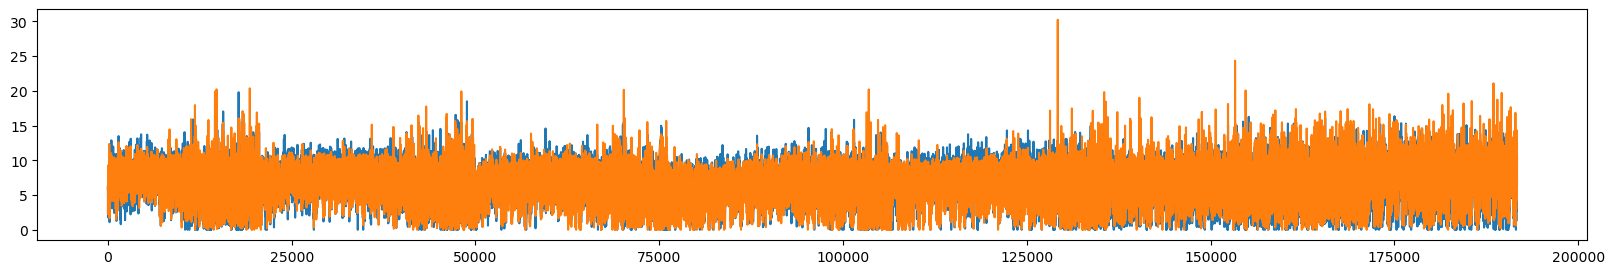

In [14]:
n1= 0
n2 = -1
plt.figure(figsize=(20,3))
plt.plot(df['U10N_TAO'][n1:n2])
plt.plot(df['U10N_QS'][n1:n2])
np.mean(df['U10N_QS'][n1:n2]-df['U10N_TAO'][n1:n2]), np.std(df['U10N_QS'][n1:n2]-df['U10N_TAO'][n1:n2]), np.corrcoef(df['U10N_TAO'][n1:n2], df['U10N_QS'][n1:n2])[0,1]

(6.115693331284253, 58.36392623363617, 0.6915115757662882)

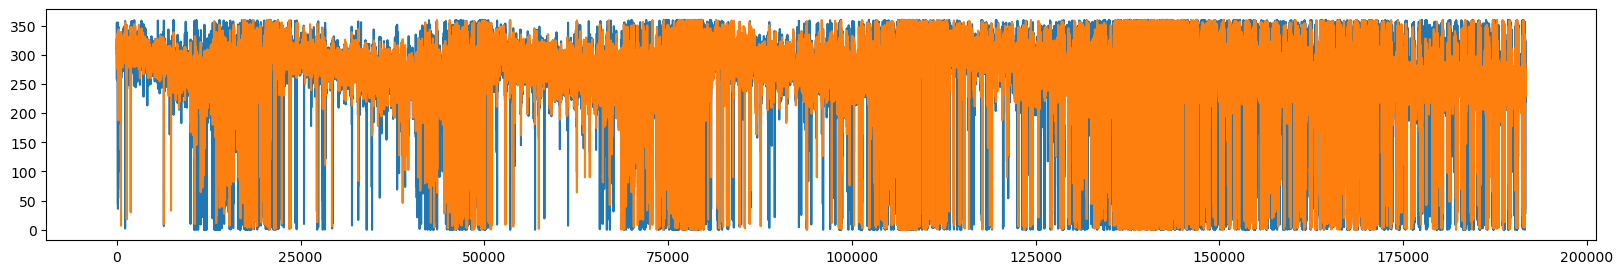

In [15]:
n1= 0
n2 = -1
plt.figure(figsize=(20,3))
plt.plot(df['U10N_dir_TAO'][n1:n2])
plt.plot(df['U10N_dir_QS'][n1:n2])
np.mean(df['U10N_dir_QS'][n1:n2]-df['U10N_dir_TAO'][n1:n2]), np.std(df['U10N_dir_QS'][n1:n2]-df['U10N_dir_TAO'][n1:n2]), np.corrcoef(df['U10N_dir_TAO'][n1:n2], df['U10N_dir_QS'][n1:n2])[0,1]

In [16]:
kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
df['label'] = kmeans.labels_

In [17]:
def plotTimeSeriesByClusterLabel(df, lat, lon, ax1, ax2, cluster_label=0, color='blue'):
    subDF = df.loc[df['lat'] == lat]
    subDF = subDF.loc[subDF['lon'] == lon%360]
    subDF = subDF.loc[subDF['label'] == cluster_label]

    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'

    
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    ds2 = Dataset(deployFileName)
    startDates = np.array(ds2.variables['startDate'])
    units = ds2.variables['startDate'].units
    cftimes = num2date(startDates, units)
    startDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

    endDates = np.array(ds2.variables['endDate'])
    units = ds2.variables['endDate'].units
    cftimes = num2date(endDates, units)
    endDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

    ds2.close()
    
    cftimes = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')
    dates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute) for dtm in cftimes])
    y1 = subDF['speedDiff']
    y2 = subDF['directionDiff']

    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        ax1.axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        ax2.axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    #ax1.scatter(subDF['time'], y1, s=2, label = cluster_label)#, c = subDF['label'])
    #ax2.scatter(subDF['time'], y2, s=2, label = cluster_label)#, c = subDF['label'])

    ax1.scatter(dates, y1, s=3, label = cluster_label, c = color)
    ax2.scatter(dates, y2, s=3, label = cluster_label, c = color)
    ax1.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} speed Diff')
    ax2.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} direction Diff')

def plotTimeSeriesAllClusterLabel(df, lat, lon, ax1, ax2):
    subDF = df.loc[df['lat'] == lat]
    subDF = subDF.loc[subDF['lon'] == lon%360]
    
    
    dates = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')

    y1 = subDF['speedDiff']
    y2 = subDF['directionDiff']
    
    ax1.scatter(subDF['time'], y1, s=2, c = subDF['Deployment Classifier'], cmap='prism')
    ax2.scatter(subDF['time'], y2, s=2, c = subDF['Deployment Classifier'], cmap='prism')

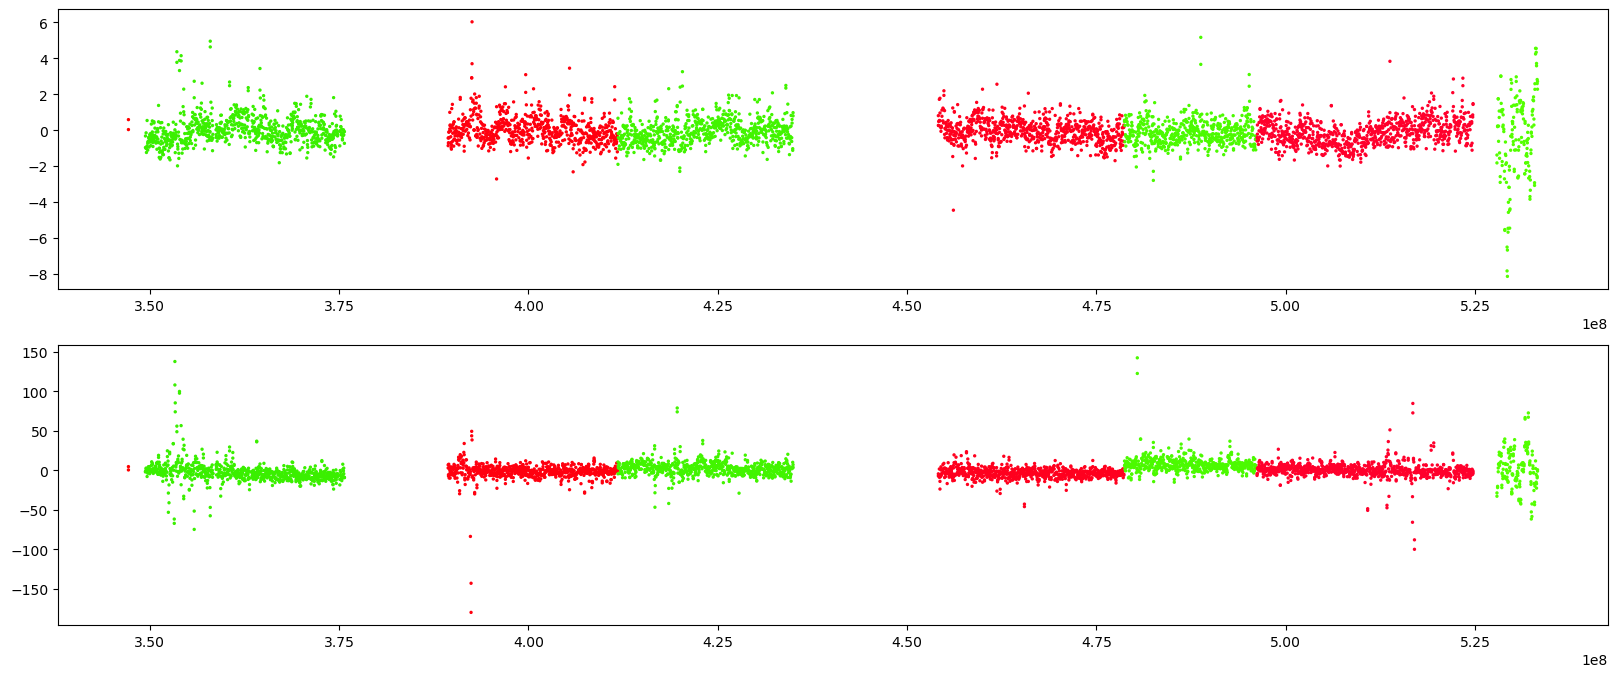

In [18]:
lat = -2
lon = -140

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
plotTimeSeriesAllClusterLabel(df, lat, lon, axes[0], axes[1])

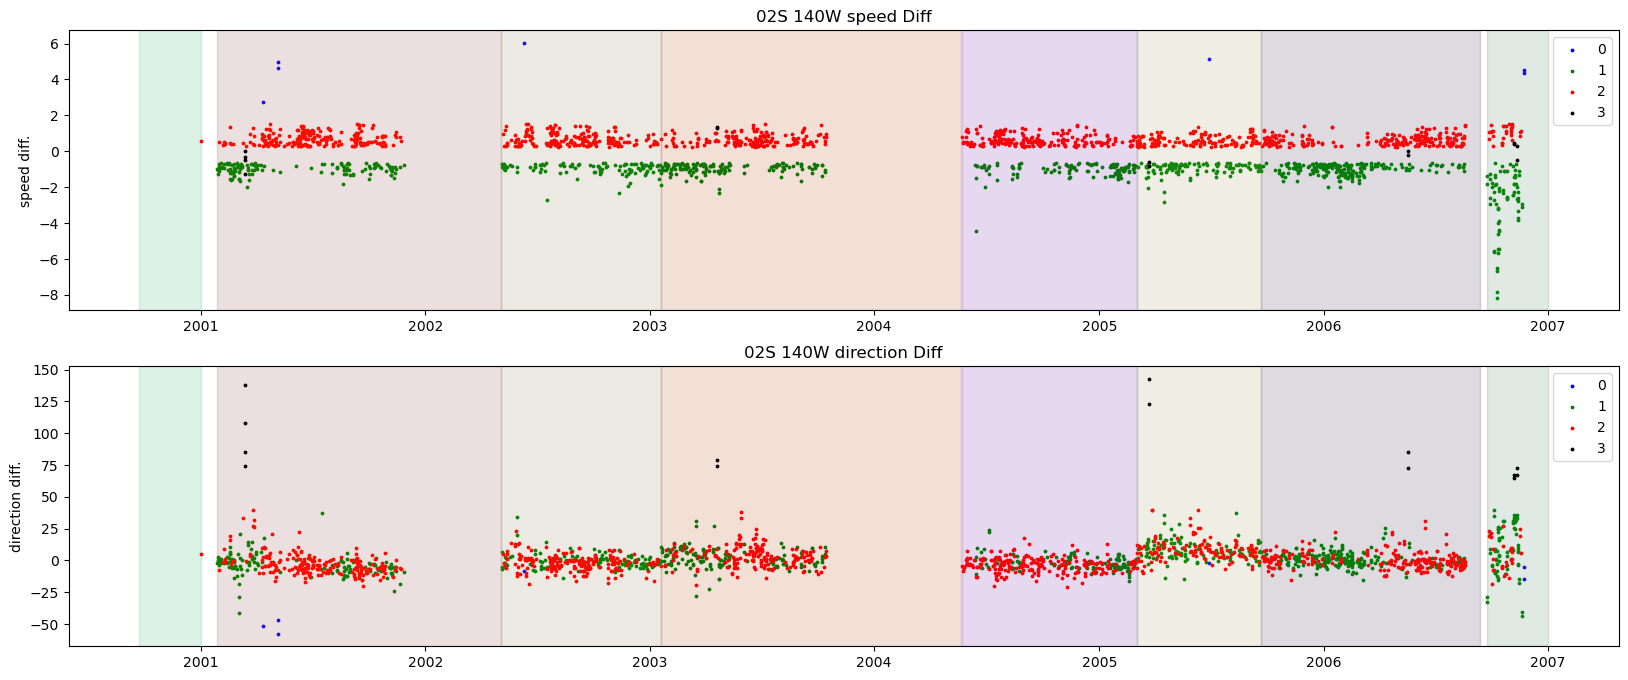

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=0, color = 'blue')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=1, color = 'green')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=2, color = 'red')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=3, color = 'black')
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=4)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=5)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=6)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=7)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=8)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=9)
axes[0].set_ylabel('speed diff.')
axes[0].legend()

axes[1].set_ylabel('direction diff.')
axes[1].legend()

In [20]:
df.head()

time  lat    lon   U10N_QS  U10N_dir_QS  satTimeDiff      dist  \
0  315534600.0 -8.0  265.0  5.747140   325.648834        276.0  6.455491   
1  315535200.0 -8.0  265.0  5.747140   325.648834       -324.0  6.455491   
2  315704400.0 -8.0  265.0  6.211579   323.708984        271.0  6.615148   
3  315705000.0 -8.0  265.0  6.211579   323.708984       -329.0  6.615148   
4  315749400.0 -8.0  265.0  5.837174   318.623627        457.0  5.688329   

       satLon    satLat  U10N_TAO  ...  wspdStd2hr_TAO  wdirStd2hr_TAO  \
0  265.053436 -7.976122  5.926161  ...        0.175726        4.020722   
1  265.053436 -7.976122  5.836925  ...        0.224447        4.074805   
2  264.974976 -7.945916  5.541527  ...        0.492311        3.546156   
3  264.974976 -7.945916  5.992860  ...        0.507882        3.787412   
4  265.045563 -7.975894  6.055364  ...        0.392188        5.910673   

   wspdMean30min_TAO  wdirMean30min_TAO  Deployment Classifier  speedDiff  \
0           5.905791         323.899994                    0.0  -0.179021   
1           5.952141         324.433329                    0.0  -0.089785   
2           5.676348         322.133331                    0.0   0.670052   
3           6.054171         320.299998                    0.0   0.218719   
4           5.905311         320.266663                    0.0  -0.218190   

   absSpeedDiff  directionDiff  absDirectionDiff  label  
0      0.179021      -0.751160          0.751160      8  
1      0.089785       3.848846          3.848846      8  
2      0.670052       2.408997          2.408997      2  
3      0.218719       3.108978          3.108978      8  
4      0.218190       0.823639          0.823639      8  

[5 rows x 28 columns]

In [21]:
import seaborn as sns

In [22]:
#sns.pairplot(data=df, x = 'hue="label")

In [23]:
subDFheaders = ['satTimeDiff',
                 'dist',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'speedDiff',
                 'directionDiff',
                 'absSpeedDiff',
                 'absDirectionDiff',
                 'label']

subDFheaders = [ 'satTimeDiff',
                 'dist',
                 # 'SST_TAO',
                 # 'RH_TAO',
                 # 'AIRT_TAO',
                 'speedDiff',
                 'directionDiff',
                 #'absSpeedDiff',
                 #'absDirectionDiff',
                 'label']

subDF = df[subDFheaders]

In [24]:
#snsPlot = sns.pairplot(data=subDF, hue="label")

In [25]:
#snsPlot.figure.savefig('allData.png', dpi = 100)

In [26]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=False, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=False, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('allDataProbDensityClusteringJustByErrorsCommonNormFalse.png', dpi = 100)

In [27]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=False, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=False, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('timeAndSpaceDistProbDensityClusteringJustByErrorsCommonNormFalse.png', dpi = 100)

In [28]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=True, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=True, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('allDataProbDensityClusteringJustByErrorsCommonNormTrue.png', dpi = 100)

In [29]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=True, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=True, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('timeAndSpaceDistProbDensityClusteringJustByErrorsCommonNormTrue.png', dpi = 100)

In [30]:
# xlabel = 'directionDiff'
# s = sns.kdeplot(subDF, x=xlabel, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [31]:
# xlabel = 'speedDiff'
# s = sns.kdeplot(subDF, x=xlabel, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [32]:
# xlabel = 'absSpeedDiff'
# ylabel = 'absDirectionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [33]:
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [34]:
# fig,  ax = plt.subplots(figsize=(8,6))
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'

# cmap = plt.get_cmap('Greys').copy()
# cmap.set_bad('white')

# h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
#                        norm=colors.LogNorm())
# cb = plt.colorbar(h1[3], ax = ax)
# cb.ax.set_title('Count')

# sA = sns.kdeplot(subDF, x=xlabel, y=ylabel,
#                     levels=20, linewidths=0.5, 
#                     palette = sns.color_palette("bright"), ax = ax)

# ax.grid(visible=True, which='both', axis='both')
# ax.set_xlim(-10,15)
# ax.set_xlabel('QS speed - TAO speed [m/s]')
# ax.set_ylabel('QS direction - TAO direction [Degrees]')
# #plt.savefig('PDF_byCluster.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

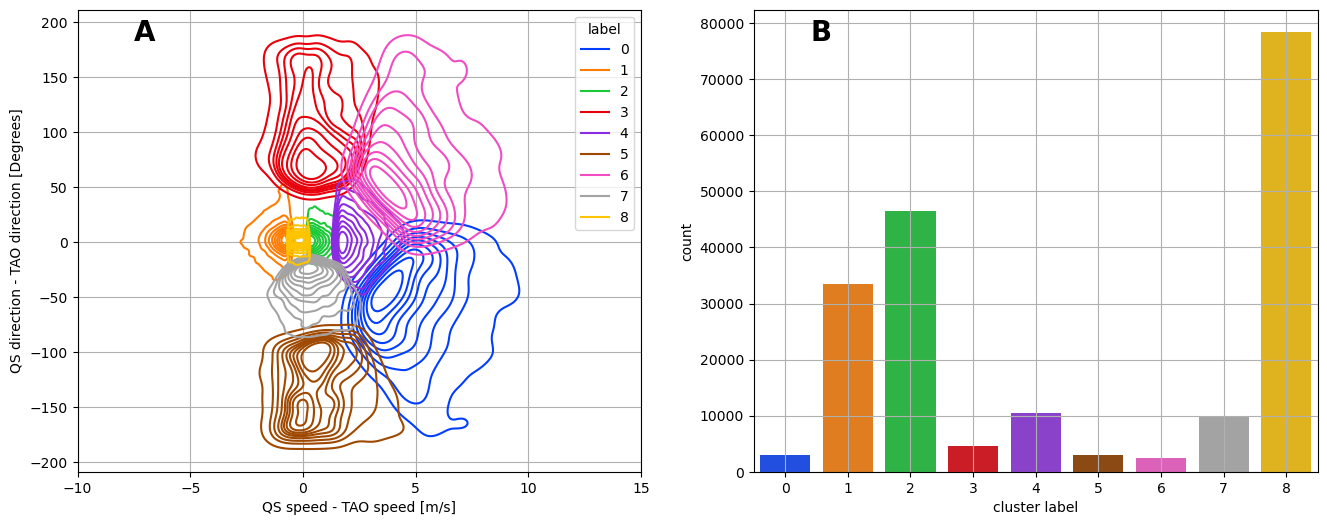

In [35]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
xlabel = 'speedDiff'
ylabel = 'directionDiff'

# sA = sns.kdeplot(subDF, x=xlabel, y=ylabel,
#                     levels=20, linewidths=0.5, 
#                     palette = sns.color_palette("bright"), ax = ax)
s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
                hue='label', common_norm=False,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('QS speed - TAO speed [m/s]')
ax.set_ylabel('QS direction - TAO direction [Degrees]')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


plt.savefig('PDF_byCluster.png', dpi=100)


In [36]:
# fig,  ax = plt.subplots(figsize=(8,6))
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# subdf = df.loc[df['label'].isin([0,2,3,5,6,8])]
# s = sns.kdeplot(subdf, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"), ax = ax)

# ax.grid(visible=True, which='both', axis='both')

In [37]:
# fig, ax = plt.subplots(figsize = (20,15))
# box_plot = sns.boxplot(df, x="label",y="speedDiff", ax = ax)

# medians = df.groupby(['label'])['speedDiff'].median()
# vertical_offset = df['speedDiff'].median() * 0.05 # offset from median for display

# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
#             horizontalalignment='center',size='x-small',color='w',weight='semibold')

In [38]:
var = 'speedDiff'
labelVal = 0

def getPDFplotFor(ax, df, labelVal, var):
    sns.histplot(df.loc[df['label'] == labelVal], x = var, ax = ax, bins = 50)
    ax.axvline(x = medians[labelVal], ymin= 0 , ymax = 0.25, color = 'r',  label = 'median')
    ax.axvline(x = means[labelVal], ymin= 0 , ymax = 0.25, color = 'blue',linestyle = '--', label = 'mean')
    ax.axvline(x = means[labelVal]-stdDevs[labelVal],  ymin= 0 , ymax = 0.25, color = 'orange', label = 'std. Dev')
    ax.axvline(x = means[labelVal]+stdDevs[labelVal],  ymin= 0 , ymax = 0.25, color = 'orange')
    
    text = f' mean: {means[labelVal]:6.2f} \n median: {medians[labelVal]:6.2f} \n stdDev: {stdDevs[labelVal]:6.2f}'
    
    
    ax.text(0.05, 0.95, text, horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha= 0.5))
    ax.legend(loc='upper right')

0 0
0 1
0 2
0 3
1 0


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

1 1
1 2
1 3


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

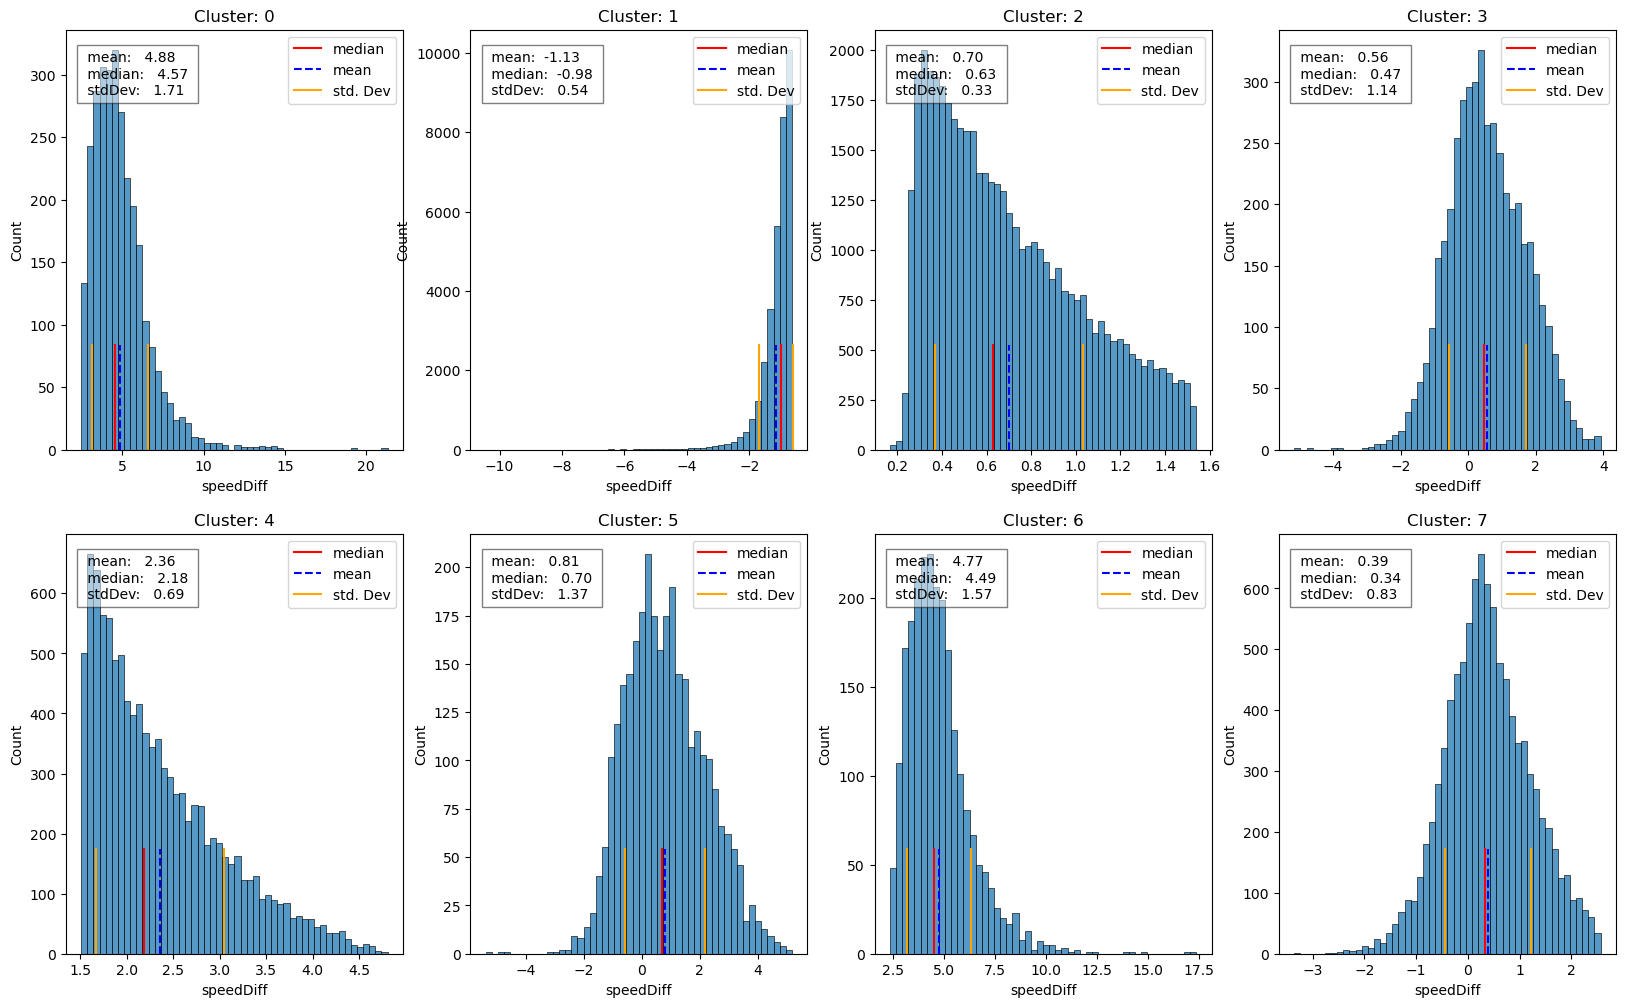

In [39]:
var = 'speedDiff'

medians = df.groupby(['label'])[var].median()
means = df.groupby(['label'])[var].mean()
stdDevs = df.groupby(['label'])[var].std()

fig,  axes = plt.subplots(nrows=2, ncols=4, figsize=(20,12))

for labelVal in range(8):
    ii = int(labelVal//4)
    jj = labelVal%4
    print(ii, jj)
    ax = axes[ii,jj]
    getPDFplotFor(ax, df, labelVal, var)
    ax.set_title('Cluster: '+ str(labelVal))
    

0 0
0 1


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

0 2
0 3
1 0
1 1
1 2


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

1 3


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


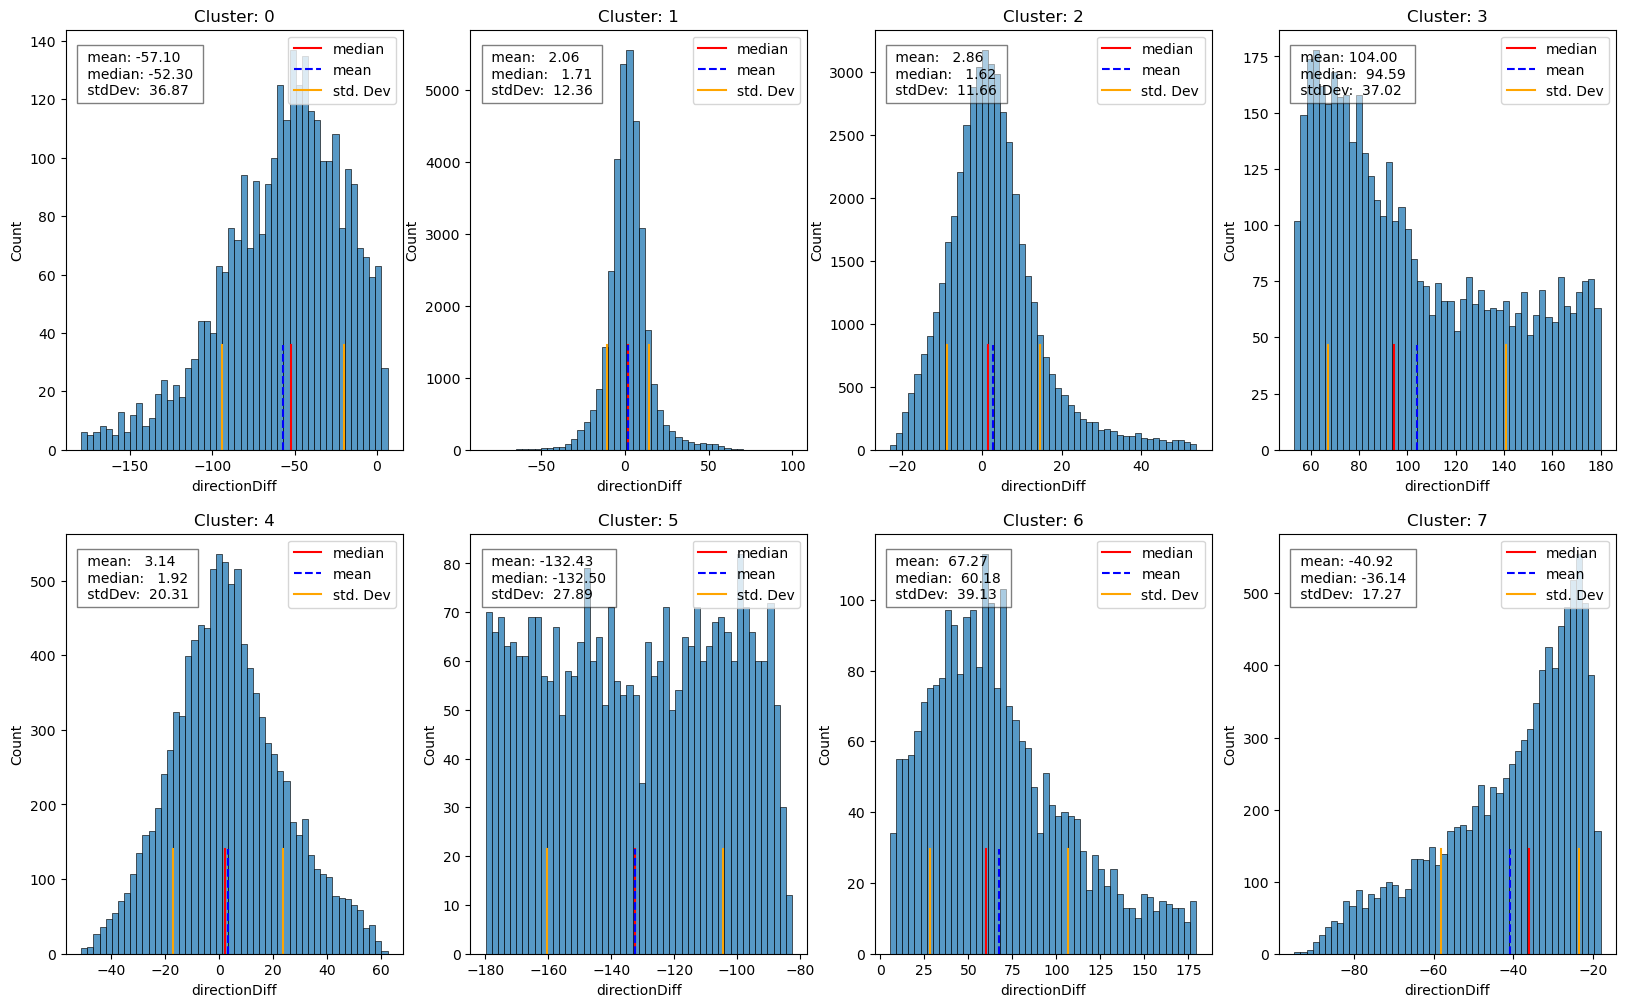

In [40]:
var = 'directionDiff'

medians = df.groupby(['label'])[var].median()
means = df.groupby(['label'])[var].mean()
stdDevs = df.groupby(['label'])[var].std()

fig,  axes = plt.subplots(nrows=2, ncols=4, figsize=(20,12))

for labelVal in range(8):
    ii = int(labelVal//4)
    jj = labelVal%4
    print(ii, jj)
    ax = axes[ii,jj]
    getPDFplotFor(ax, df, labelVal, var)
    ax.set_title('Cluster: '+ str(labelVal))


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'cluster label')

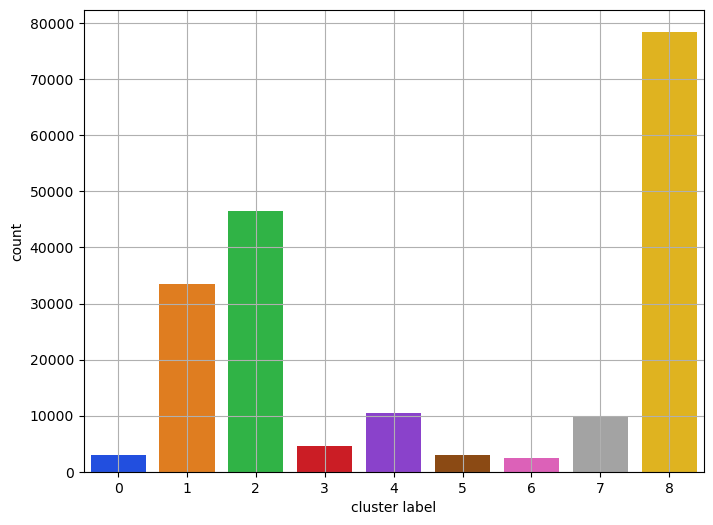

In [41]:
fig,  ax = plt.subplots(figsize=(8,6))
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

In [42]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([0,3,4,5,6,7])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad



191686


In [43]:
def getGoodBad(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        

        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999

def getCount(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        count = len(subDF) #.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        return count
    else:
        return -999


def getSpeedCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSspeed = subDF['U10N_QS'].to_numpy()
        TAOspeed = subDF['U10N_TAO'].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999


def getXSpeedCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSspeed = subDF['U10N_QS'].to_numpy()
        QSdir = (-subDF['U10N_dir_QS'].to_numpy()-90)%360
        TAOspeed = subDF['U10N_TAO'].to_numpy()
        TAOdir = (-subDF['U10N_dir_TAO'].to_numpy()-90)%360
        QSspeed_x = QSspeed * np.cos(np.deg2rad(QSdir))
        TAOspeed_x = TAOspeed * np.cos(np.deg2rad(TAOdir))
        corr = np.corrcoef(QSspeed_x, TAOspeed_x)[0,1]
        return corr
    else:
        return -999

def getYSpeedCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSspeed = subDF['U10N_QS'].to_numpy()
        QSdir = (-subDF['U10N_dir_QS'].to_numpy()-90)%360
        TAOspeed = subDF['U10N_TAO'].to_numpy()
        TAOdir = (-subDF['U10N_dir_TAO'].to_numpy()-90)%360
        QSspeed_y = QSspeed * np.sin(np.deg2rad(QSdir))
        TAOspeed_y = TAOspeed * np.sin(np.deg2rad(TAOdir))      
        corr = np.corrcoef(QSspeed_y, TAOspeed_y)[0,1]
        return corr
    else:
        return -999


def getDirCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSdir = subDF['U10N_dir_QS'].to_numpy()
        TAOdir = subDF['U10N_dir_TAO'].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999
    

In [44]:
getGoodBad(0, -140, df), getBadPercent(0, -140, df), 

('  96,  4', 4.192286193404136)

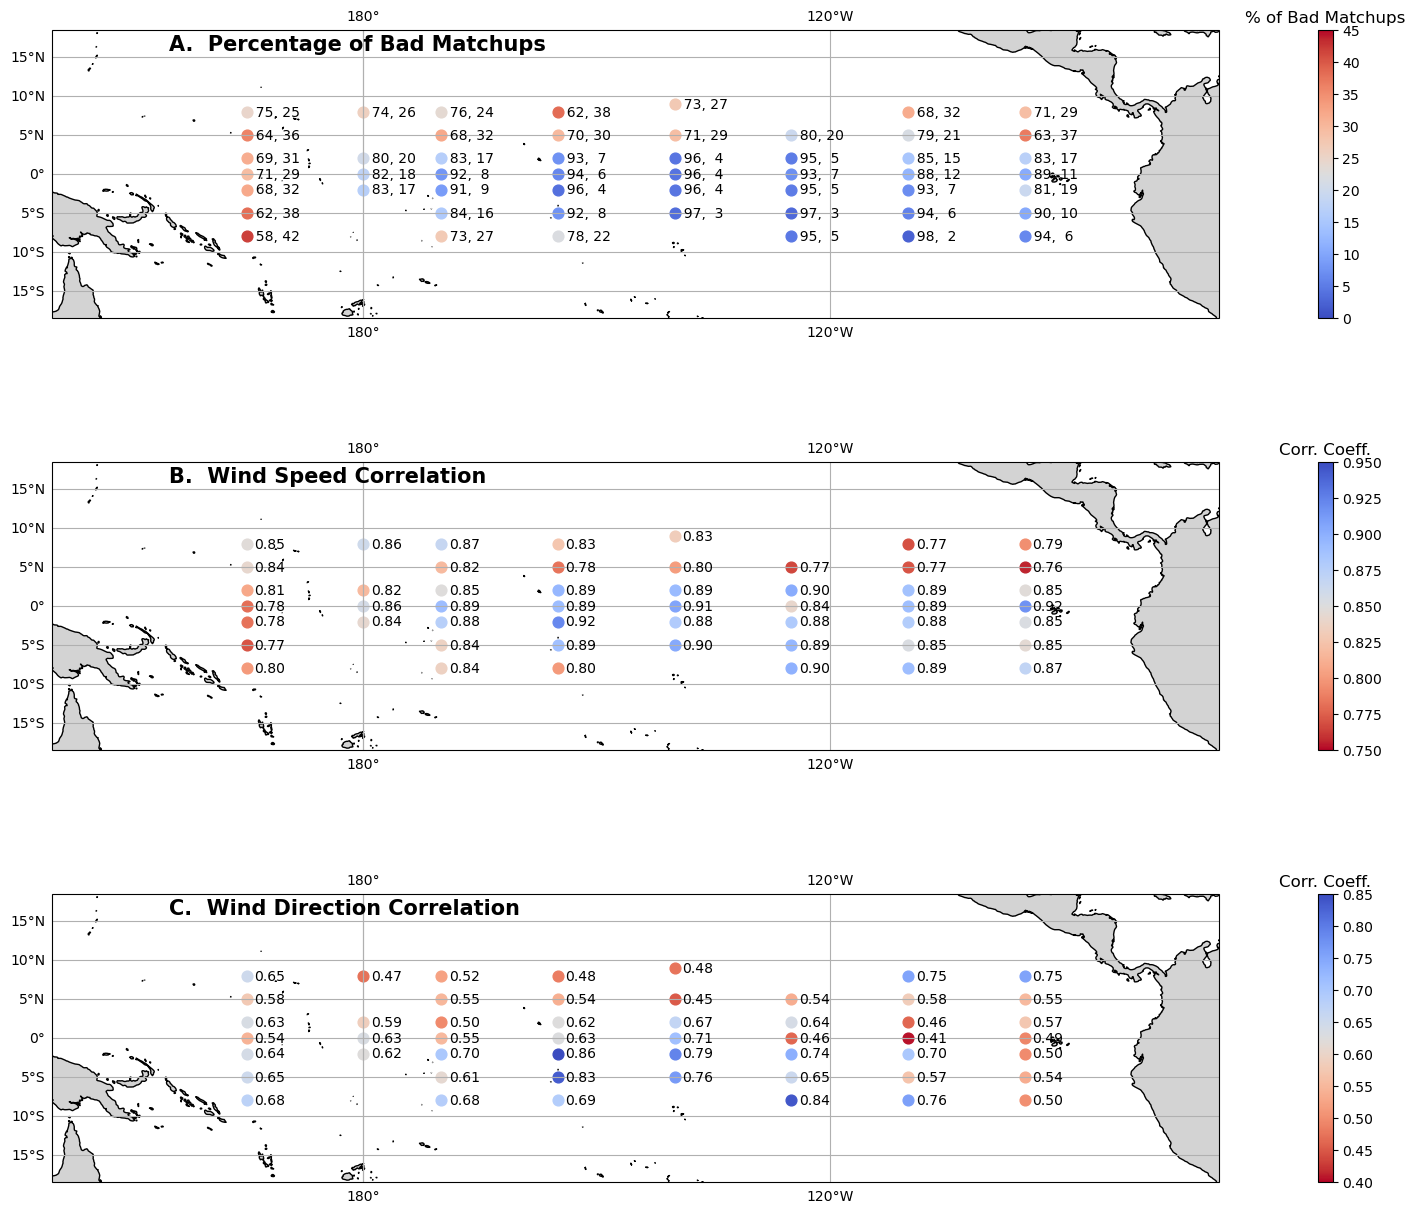

In [45]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=45, s=60, cmap='coolwarm')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.75, vmax=0.95, s=60, cmap='coolwarm_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.40, vmax=0.85, s=60, cmap='coolwarm_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

plt.savefig('goodVsBad.png', dpi=100)


In [46]:
cdfDates = num2date(df['time'], 'seconds since 1990-01-01 00:00:00')
dateTime = np.array([datetime(cdf.year, cdf.month, cdf.day, cdf.hour, cdf.minute) for cdf in cdfDates])
day_of_year = np.array([date.timetuple().tm_yday for date in dateTime])
df['dateTime'] = dateTime
df['day'] = day_of_year

In [47]:
def getWindSpedStd(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        mean_wspdStd2hr	 = np.mean(subDF['wspdStd2hr_TAO'])
        return mean_wspdStd2hr
    else:
        return -999


def getWindDirStd(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        mean_wspdStd2hr	 = np.mean(subDF['wdirStd2hr_TAO'])
        return mean_wspdStd2hr
    else:
        return -999
    

In [48]:
df.head()

time  lat    lon   U10N_QS  U10N_dir_QS  satTimeDiff      dist  \
0  315534600.0 -8.0  265.0  5.747140   325.648834        276.0  6.455491   
1  315535200.0 -8.0  265.0  5.747140   325.648834       -324.0  6.455491   
2  315704400.0 -8.0  265.0  6.211579   323.708984        271.0  6.615148   
3  315705000.0 -8.0  265.0  6.211579   323.708984       -329.0  6.615148   
4  315749400.0 -8.0  265.0  5.837174   318.623627        457.0  5.688329   

       satLon    satLat  U10N_TAO  ...  wdirMean30min_TAO  \
0  265.053436 -7.976122  5.926161  ...         323.899994   
1  265.053436 -7.976122  5.836925  ...         324.433329   
2  264.974976 -7.945916  5.541527  ...         322.133331   
3  264.974976 -7.945916  5.992860  ...         320.299998   
4  265.045563 -7.975894  6.055364  ...         320.266663   

   Deployment Classifier  speedDiff  absSpeedDiff  directionDiff  \
0                    0.0  -0.179021      0.179021      -0.751160   
1                    0.0  -0.089785      0.089785       3.848846   
2                    0.0   0.670052      0.670052       2.408997   
3                    0.0   0.218719      0.218719       3.108978   
4                    0.0  -0.218190      0.218190       0.823639   

   absDirectionDiff  label  GoodBad            dateTime  day  
0          0.751160      8     good 2000-01-01 00:30:00    1  
1          3.848846      8     good 2000-01-01 00:40:00    1  
2          2.408997      2     good 2000-01-02 23:40:00    2  
3          3.108978      8     good 2000-01-02 23:50:00    2  
4          0.823639      8     good 2000-01-03 12:10:00    3  

[5 rows x 31 columns]

/tmp/ipykernel_1194369/314768792.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


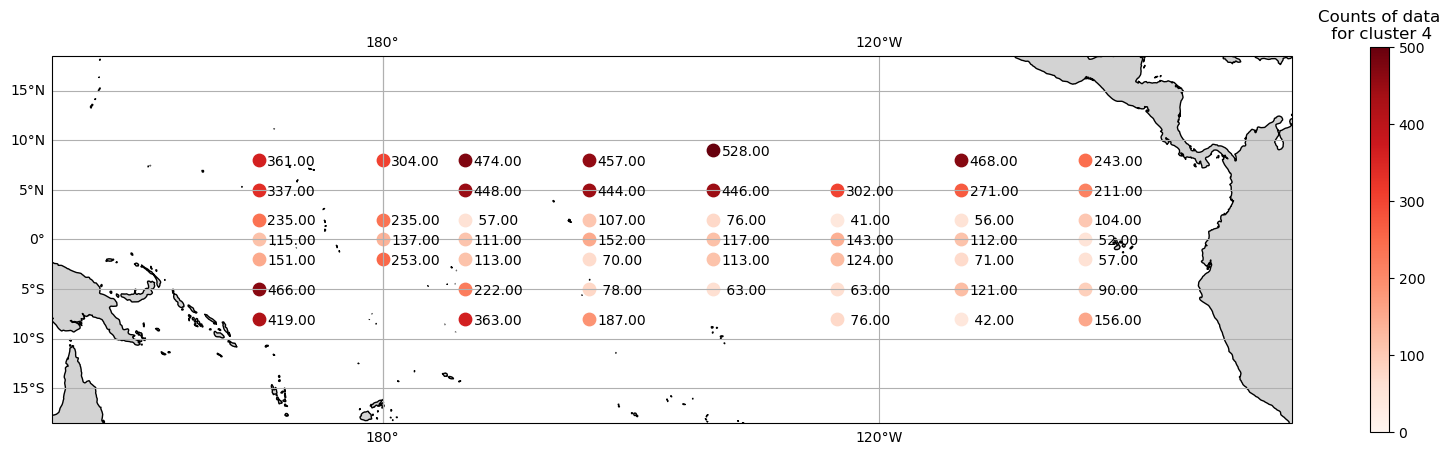

In [49]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['label'] == 4]

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = str(getCount(lat, lon, subDF))
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd = getCount(lat, lon, subDF)
    if wspdStd != -999: 
        #print(wspdStd)
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=0, vmax=500, s=80,  cmap='Reds')
    
cb = plt.colorbar(x)
cb.ax.set_title('Counts of data\n for cluster 4')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

plt.tight_layout()
#plt.savefig('goodVsBad.png', dpi=100)
    


/tmp/ipykernel_1194369/1968891746.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


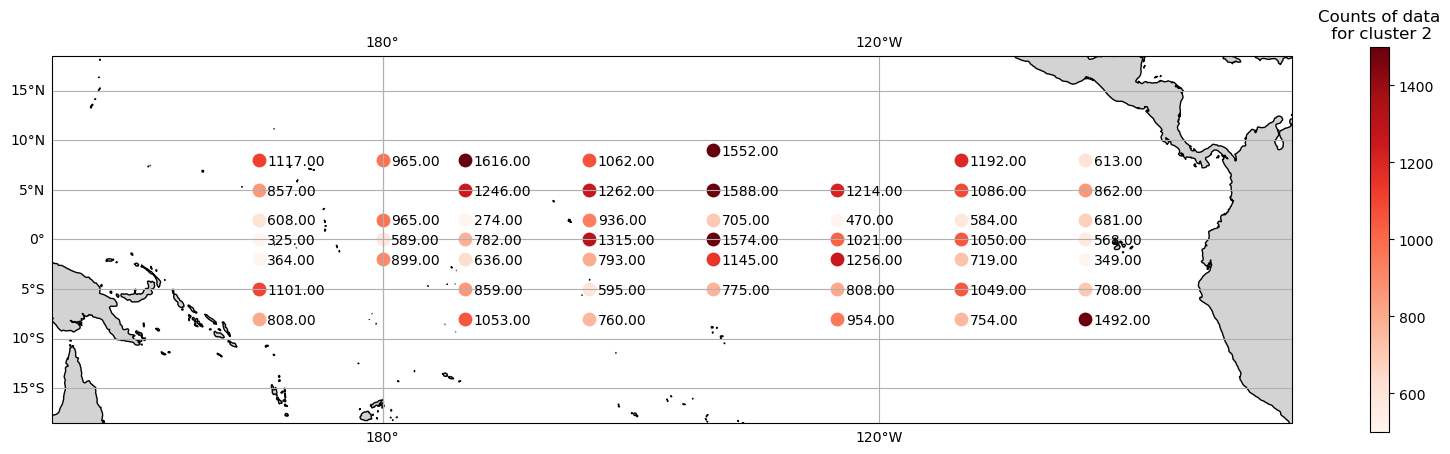

In [50]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['label'] == 2]

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = str(getCount(lat, lon, subDF))
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd = getCount(lat, lon, subDF)
    if wspdStd != -999: 
        #print(wspdStd)
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=500, vmax=1500, s=80,  cmap='Reds')
    
cb = plt.colorbar(x)
cb.ax.set_title('Counts of data\n for cluster 2')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

plt.tight_layout()
#plt.savefig('goodVsBad.png', dpi=100)
    


/tmp/ipykernel_1194369/167629565.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


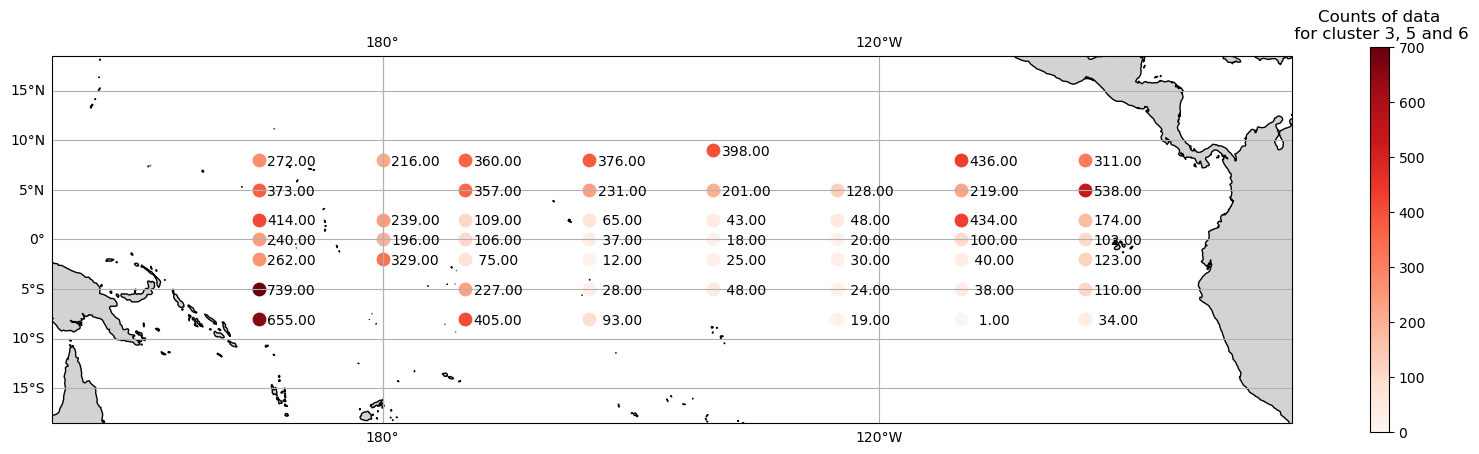

In [51]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['label'].isin([3,5,6])]

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = str(getCount(lat, lon, subDF))
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd = getCount(lat, lon, subDF)
    if wspdStd != -999: 
        #print(wspdStd)
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=0, vmax=700, s=80,  cmap='Reds')
    
cb = plt.colorbar(x)
cb.ax.set_title('Counts of data\n for cluster 3, 5 and 6')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

plt.tight_layout()
#plt.savefig('goodVsBad.png', dpi=100)
    


/tmp/ipykernel_1194369/1218938429.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


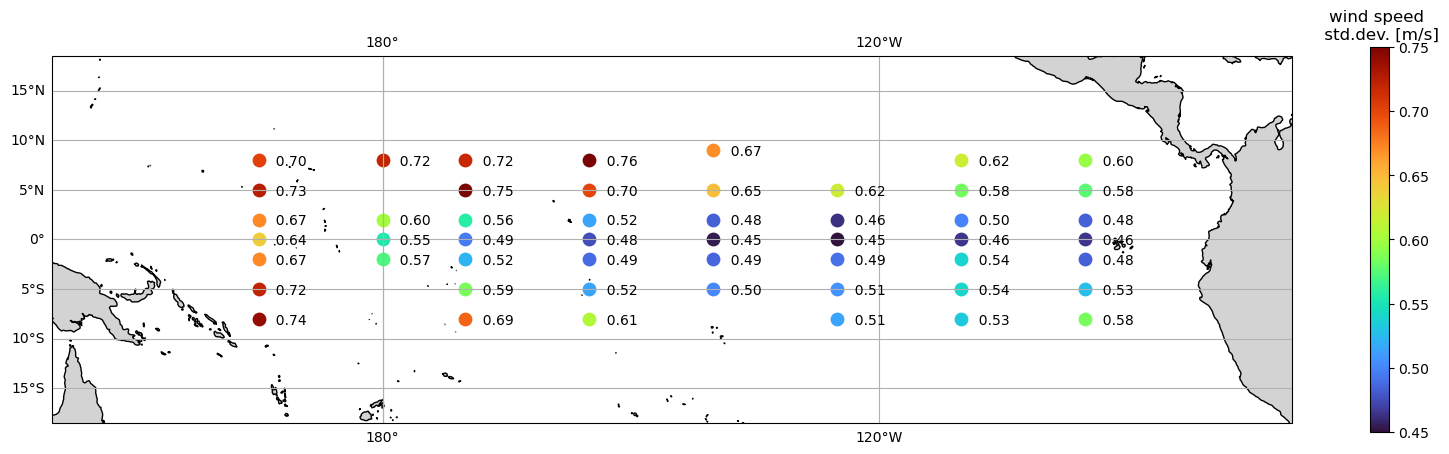

In [52]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wspdStd = getWindSpedStd(lat, lon, df)
    if wspdStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wspdStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wspdStd, vmin=0.45, vmax=0.75, s=80,  cmap='turbo')
    
cb = plt.colorbar(x)
cb.ax.set_title('wind speed \n std.dev. [m/s]')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)
    


/tmp/ipykernel_1194369/194776678.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


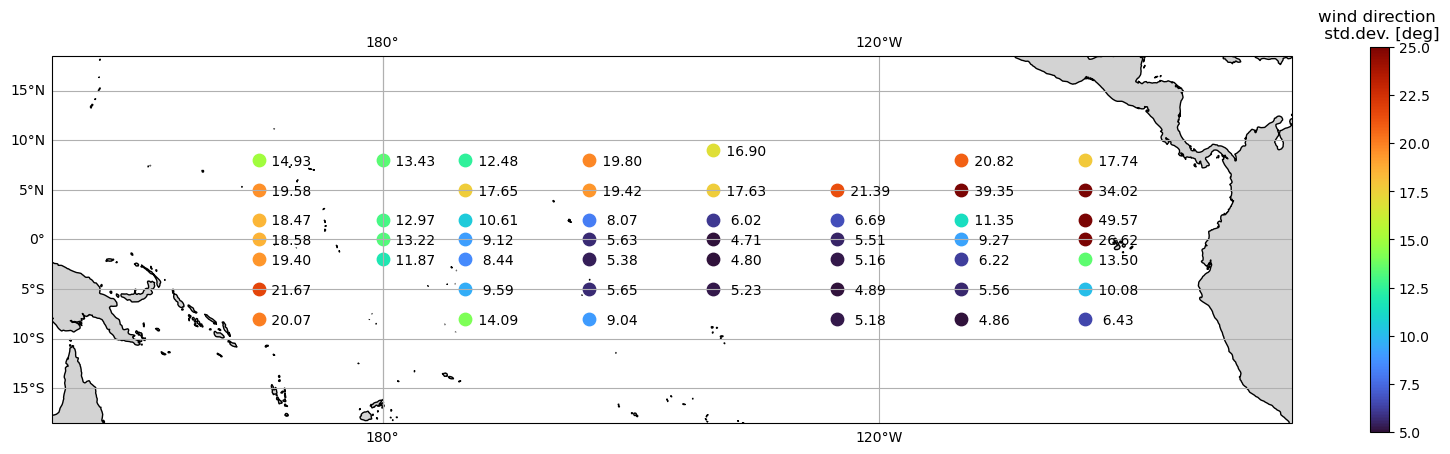

In [53]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    wdirStd = getWindDirStd(lat, lon, df)
    if wdirStd != -999: 
        ax.text(xpos+1, lat-0.5, f'{wdirStd:6.2f}')
        x = ax.scatter(xpos, lat, c=wdirStd, vmin=5, vmax=25, s=80,  cmap='turbo')
    
cb = plt.colorbar(x)
cb.ax.set_title('wind direction \n std.dev. [deg]')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

plt.tight_layout()
# plt.savefig('goodVsBad.png', dpi=100)
    

In [54]:
def get30minMeanSpeedCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSspeed = subDF['U10N_QS'].to_numpy()
        TAOspeed = subDF['wspdMean30min_TAO'].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999


def get30minMeanDirCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSdir = subDF['U10N_dir_QS'].to_numpy()
        TAOdir = subDF['wdirMean30min_TAO'].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

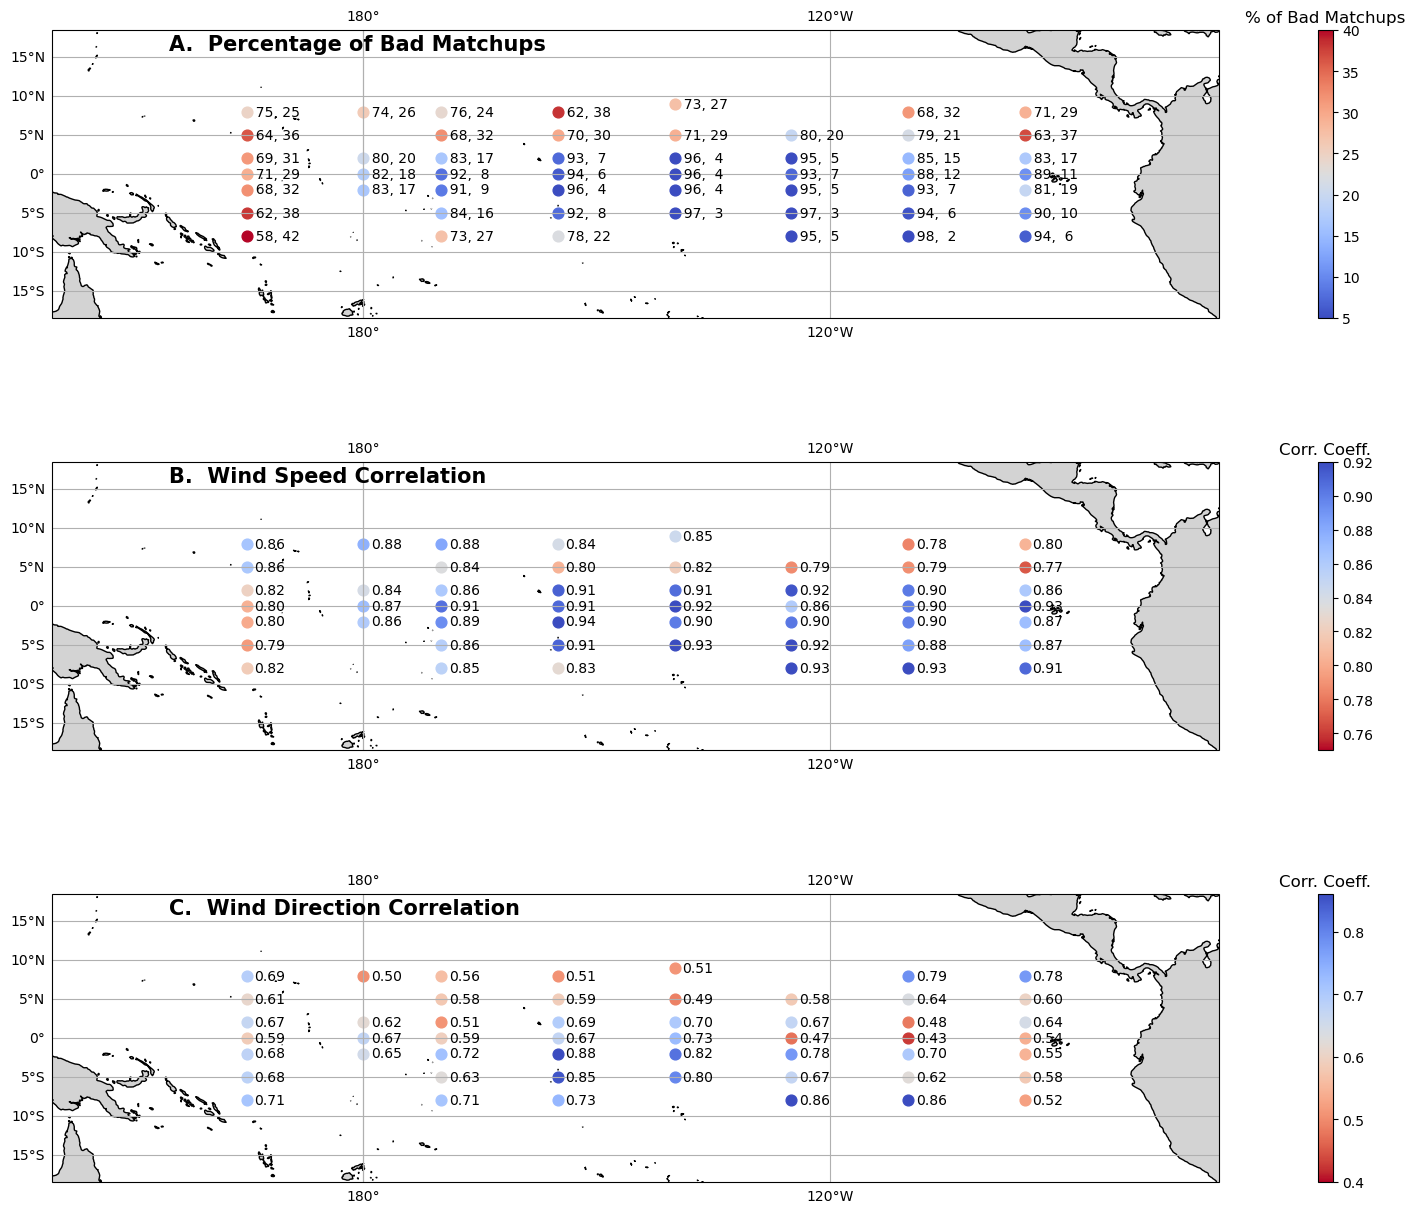

In [55]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=5, vmax=40, s=60, cmap='coolwarm')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('% of Bad Matchups')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanSpeedCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.75, vmax=0.92, s=60, cmap='coolwarm_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanDirCorrelation(lat, lon, df)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.4, vmax=0.86, s=60, cmap='coolwarm_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)
    


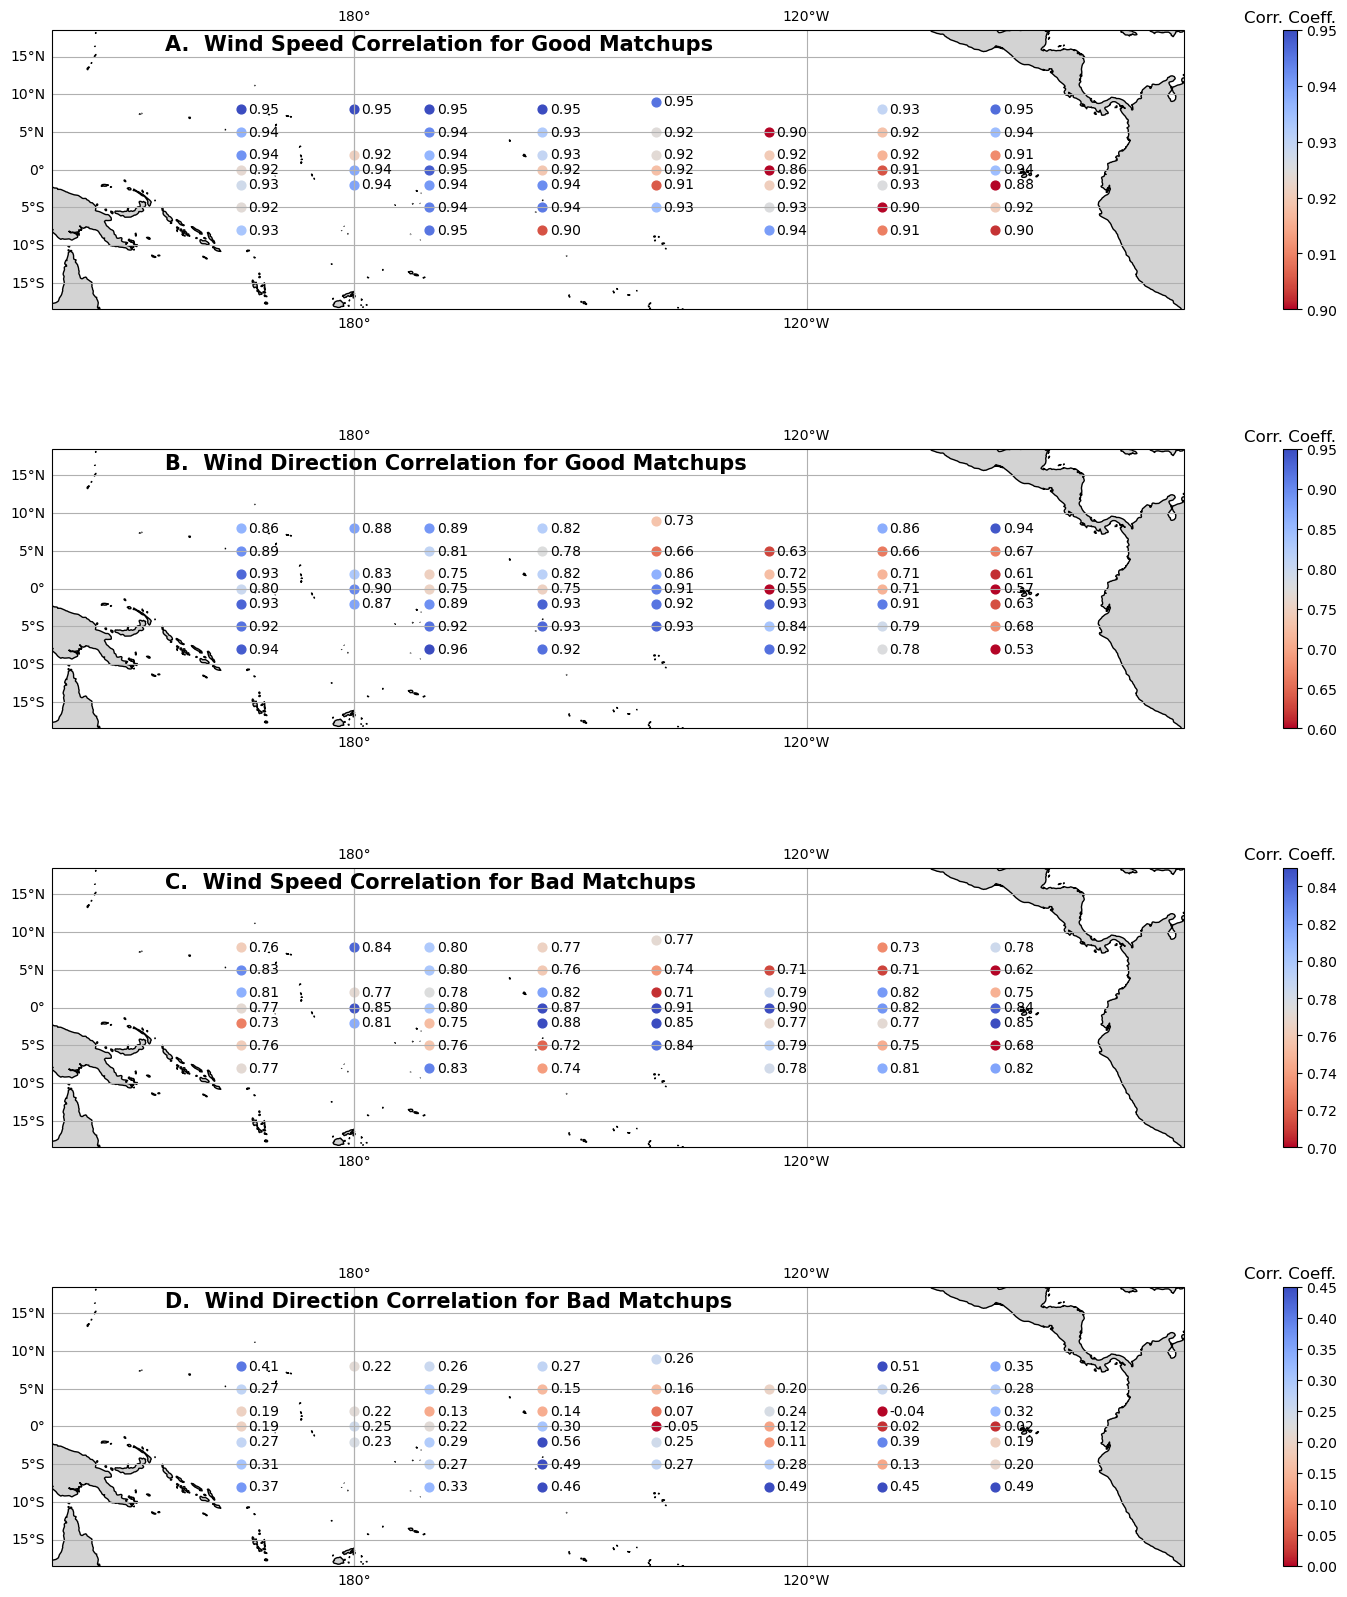

In [56]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 4, 
                       ncols = 1, 
                        figsize = (20,16),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x1 = ax.scatter(xpos, lat, c=corr, vmin=0.90, vmax=0.95, s=40, cmap='coolwarm_r')
    
cb = plt.colorbar(x1, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'A.  Wind Speed Correlation for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x2 = ax.scatter(xpos, lat, c=corr, vmin=0.60, vmax=0.95, s=40, cmap='coolwarm_r')
    
cb = plt.colorbar(x2, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'B.  Wind Direction Correlation for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x3 = ax.scatter(xpos, lat, c=corr, vmin=0.70, vmax=0.85, s=40, cmap='coolwarm_r')
    
cb = plt.colorbar(x3, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'C.  Wind Speed Correlation for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[3]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x4 = ax.scatter(xpos, lat, c=corr, vmin=0.0, vmax=0.45, s=40, cmap='coolwarm_r')
    
cb = plt.colorbar(x4, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'D.  Wind Direction Correlation for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

plt.savefig('goodVsBad_byMatchupLabel.png', dpi=100)

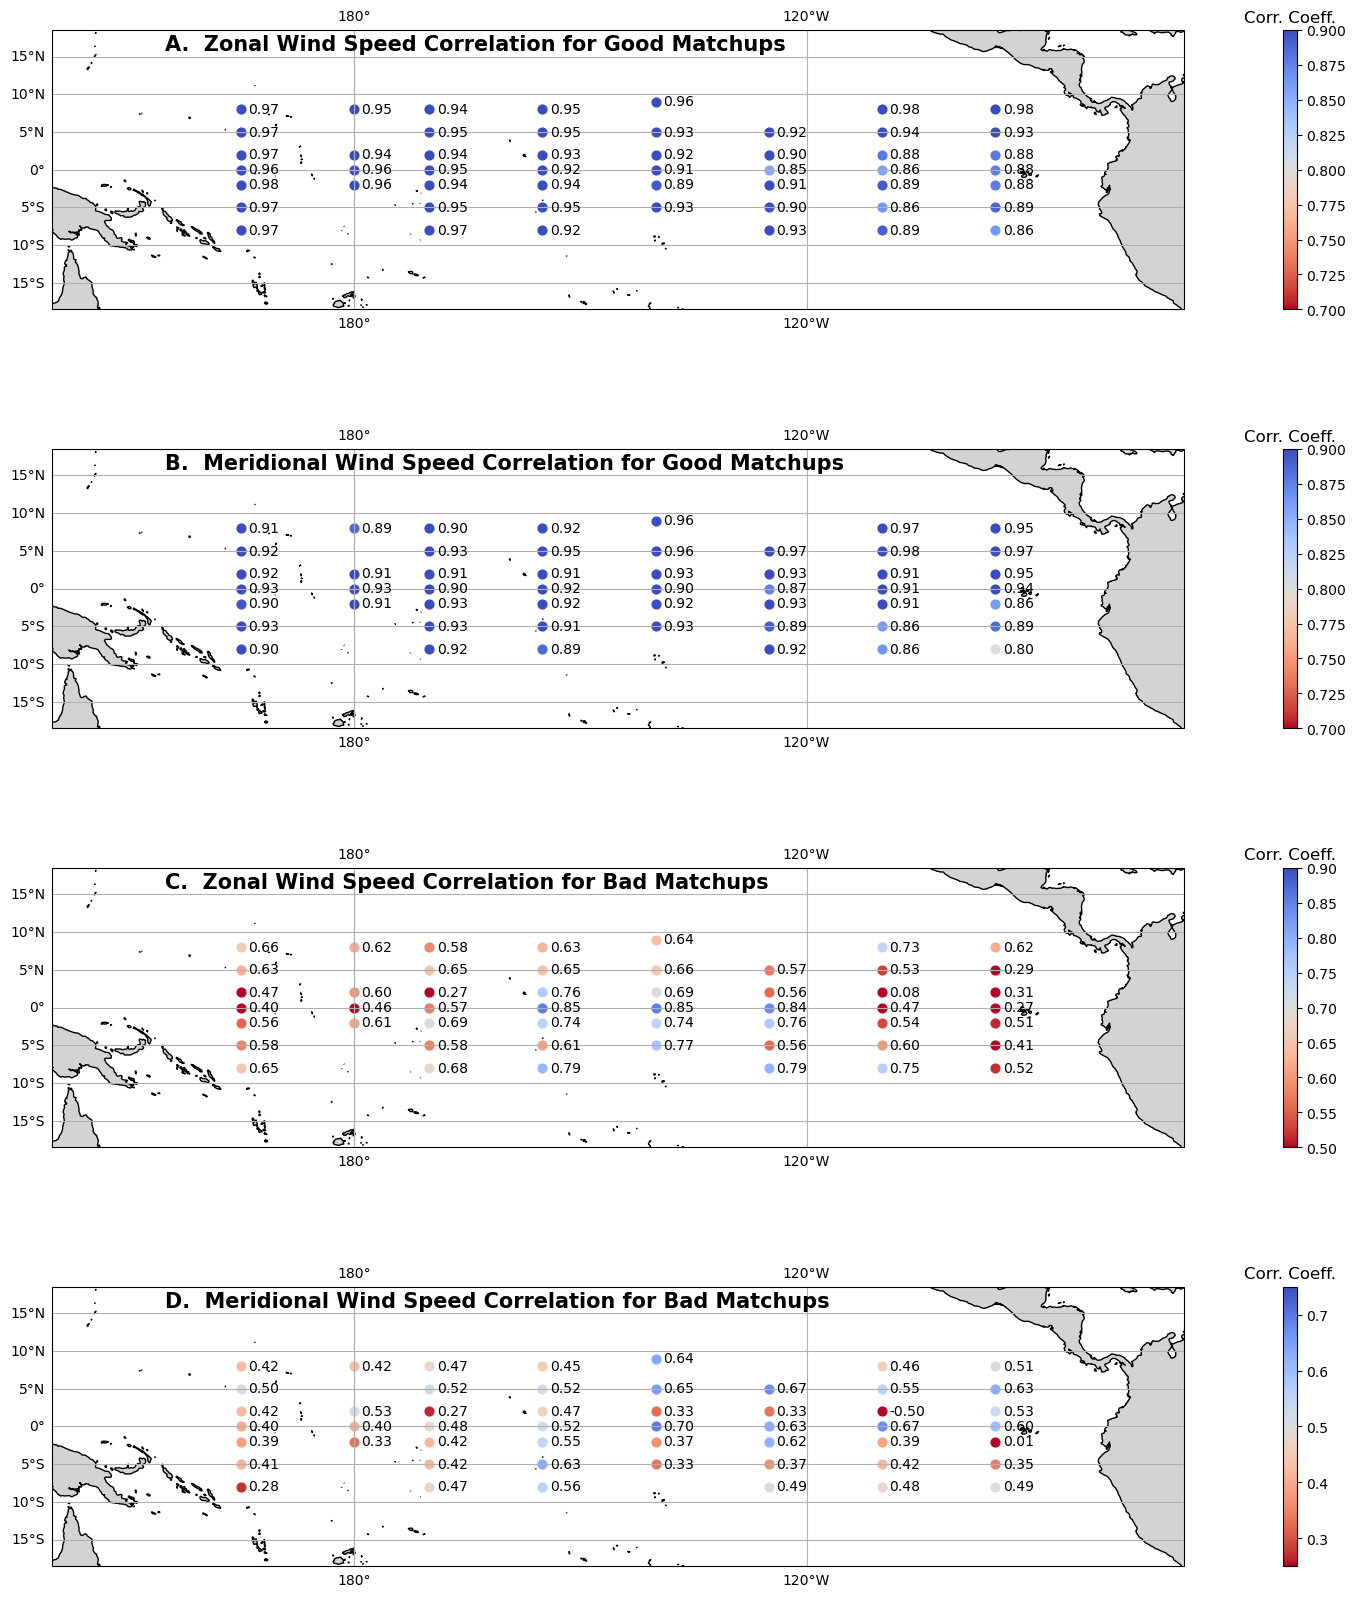

In [57]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 4, 
                       ncols = 1, 
                        figsize = (20,16),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getXSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x1 = ax.scatter(xpos, lat, c=corr, vmin=0.70, vmax=0.9, s=40, cmap='coolwarm_r')
    
cb = plt.colorbar(x1, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'A.  Zonal Wind Speed Correlation for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getYSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x2 = ax.scatter(xpos, lat, c=corr, vmin=0.70, vmax=0.9, s=40, cmap='coolwarm_r')
    
cb = plt.colorbar(x2, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'B.  Meridional Wind Speed Correlation for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getXSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x3 = ax.scatter(xpos, lat, c=corr, vmin=0.50, vmax=0.9, s=40, cmap='coolwarm_r')
    
cb = plt.colorbar(x3, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'C.  Zonal Wind Speed Correlation for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[3]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getYSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x4 = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=40, cmap='coolwarm_r')
    
cb = plt.colorbar(x4, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'D.  Meridional Wind Speed Correlation for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

plt.savefig('goodVsBad_byMatchupLabelComponents.png', dpi=100)

In [58]:
df.head()

time  lat    lon   U10N_QS  U10N_dir_QS  satTimeDiff      dist  \
0  315534600.0 -8.0  265.0  5.747140   325.648834        276.0  6.455491   
1  315535200.0 -8.0  265.0  5.747140   325.648834       -324.0  6.455491   
2  315704400.0 -8.0  265.0  6.211579   323.708984        271.0  6.615148   
3  315705000.0 -8.0  265.0  6.211579   323.708984       -329.0  6.615148   
4  315749400.0 -8.0  265.0  5.837174   318.623627        457.0  5.688329   

       satLon    satLat  U10N_TAO  ...  wdirMean30min_TAO  \
0  265.053436 -7.976122  5.926161  ...         323.899994   
1  265.053436 -7.976122  5.836925  ...         324.433329   
2  264.974976 -7.945916  5.541527  ...         322.133331   
3  264.974976 -7.945916  5.992860  ...         320.299998   
4  265.045563 -7.975894  6.055364  ...         320.266663   

   Deployment Classifier  speedDiff  absSpeedDiff  directionDiff  \
0                    0.0  -0.179021      0.179021      -0.751160   
1                    0.0  -0.089785      0.089785       3.848846   
2                    0.0   0.670052      0.670052       2.408997   
3                    0.0   0.218719      0.218719       3.108978   
4                    0.0  -0.218190      0.218190       0.823639   

   absDirectionDiff  label  GoodBad            dateTime  day  
0          0.751160      8     good 2000-01-01 00:30:00    1  
1          3.848846      8     good 2000-01-01 00:40:00    1  
2          2.408997      2     good 2000-01-02 23:40:00    2  
3          3.108978      8     good 2000-01-02 23:50:00    2  
4          0.823639      8     good 2000-01-03 12:10:00    3  

[5 rows x 31 columns]

In [59]:
def getmeanSpeedDiff(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        meanSpeedDiff = np.nanmean(subDF['speedDiff'].to_numpy())
        return meanSpeedDiff
    else:
        return -999

def getmeanXSpeedDiff(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSspeed = subDF['U10N_QS'].to_numpy()
        QSdir = subDF['U10N_dir_QS'].to_numpy()
        TAOspeed = subDF['U10N_TAO'].to_numpy()
        TAOdir = subDF['U10N_dir_TAO'].to_numpy()
        QSspeed_x = QSspeed * np.sin(np.deg2rad(QSdir))
        TAOspeed_x = TAOspeed * np.sin(np.deg2rad(TAOdir))  
        meanSpeedDiff = np.nanmean(QSspeed_x - TAOspeed_x)
        return meanSpeedDiff
    else:
        return -999


def getmeanYSpeedDiff(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSspeed = subDF['U10N_QS'].to_numpy()
        QSdir = subDF['U10N_dir_QS'].to_numpy()
        TAOspeed = subDF['U10N_TAO'].to_numpy()
        TAOdir = subDF['U10N_dir_TAO'].to_numpy()
        QSspeed_y = QSspeed * np.cos(np.deg2rad(QSdir))
        TAOspeed_y = TAOspeed * np.cos(np.deg2rad(TAOdir))  
        meanSpeedDiff = np.nanmean(QSspeed_y - TAOspeed_y)
        return meanSpeedDiff
    else:
        return -999


def getmeanDirectionDiff(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        meanDirectionDiff = np.nanmean(subDF['directionDiff'].to_numpy())
        return meanDirectionDiff
    else:
        return -999

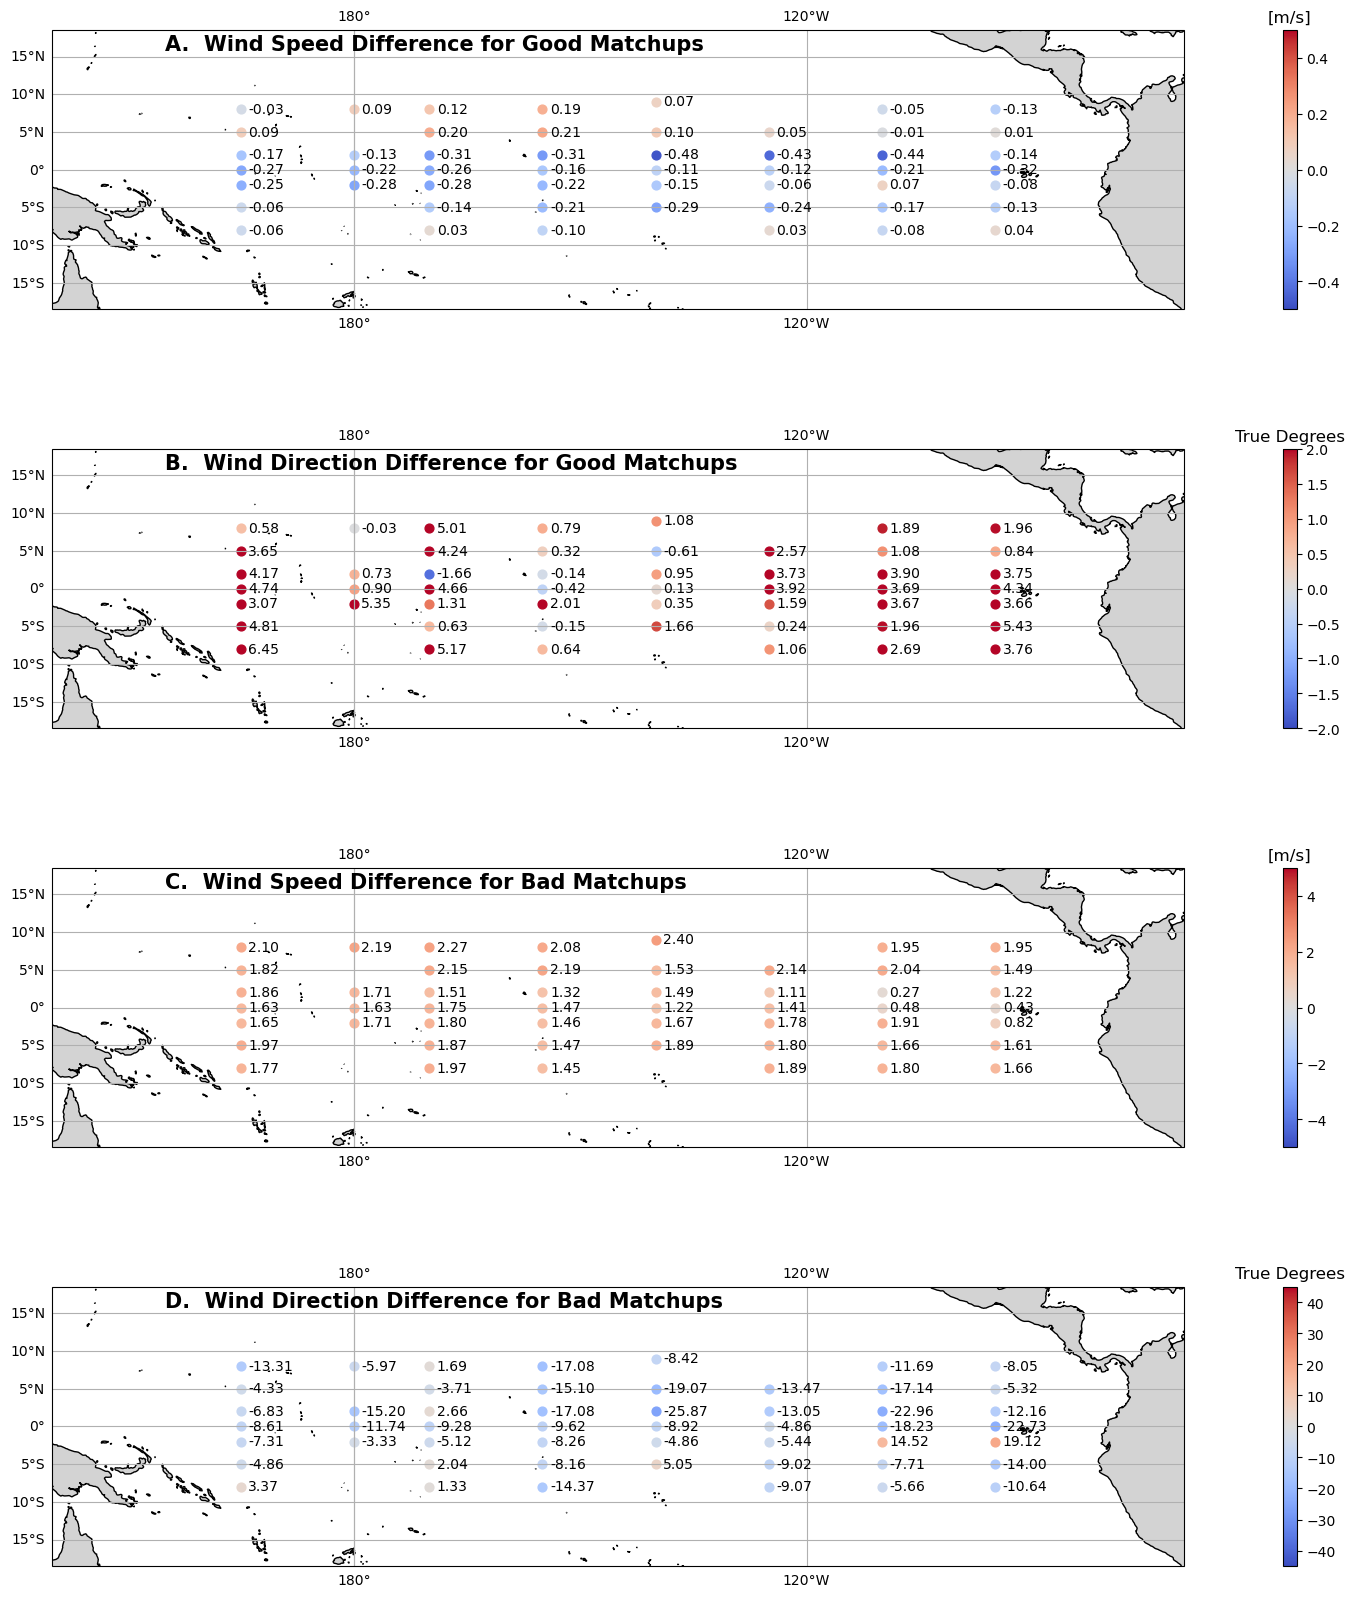

In [60]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 4, 
                       ncols = 1, 
                        figsize = (20,16),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    diff = getmeanSpeedDiff(lat, lon, subDF)
    if diff != -999: 
        ax.text(xpos+1, lat-0.5, f'{diff:4.2f}', fontsize = 10)
        x1 = ax.scatter(xpos, lat, c=diff, vmin=-0.5, vmax=0.5, s=40, cmap='coolwarm')
    
cb = plt.colorbar(x1, ax = ax)
cb.ax.set_title('[m/s]')

ax.text(0.1, 0.95, 'A.  Wind Speed Difference for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getmeanDirectionDiff(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x2 = ax.scatter(xpos, lat, c=corr, vmin=-2, vmax=2, s=40, cmap='coolwarm')
    
cb = plt.colorbar(x2, ax = ax)
cb.ax.set_title('True Degrees')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'B.  Wind Direction Difference for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    diff = getmeanSpeedDiff(lat, lon, subDF)
    if diff != -999: 
        ax.text(xpos+1, lat-0.5, f'{diff:4.2f}', fontsize = 10)
        x3 = ax.scatter(xpos, lat, c=diff, vmin=-5, vmax=5, s=40, cmap='coolwarm')
    
cb = plt.colorbar(x3, ax = ax)
cb.ax.set_title('[m/s]')

ax.text(0.1, 0.95, 'C.  Wind Speed Difference for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[3]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getmeanDirectionDiff(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x4 = ax.scatter(xpos, lat, c=corr, vmin=-45, vmax=45, s=40, cmap='coolwarm')
    
cb = plt.colorbar(x4, ax = ax)
cb.ax.set_title('True Degrees')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'D.  Wind Direction Difference for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

plt.savefig('goodVsBad_DifferencesbyMatchupLabel.png', dpi=100)

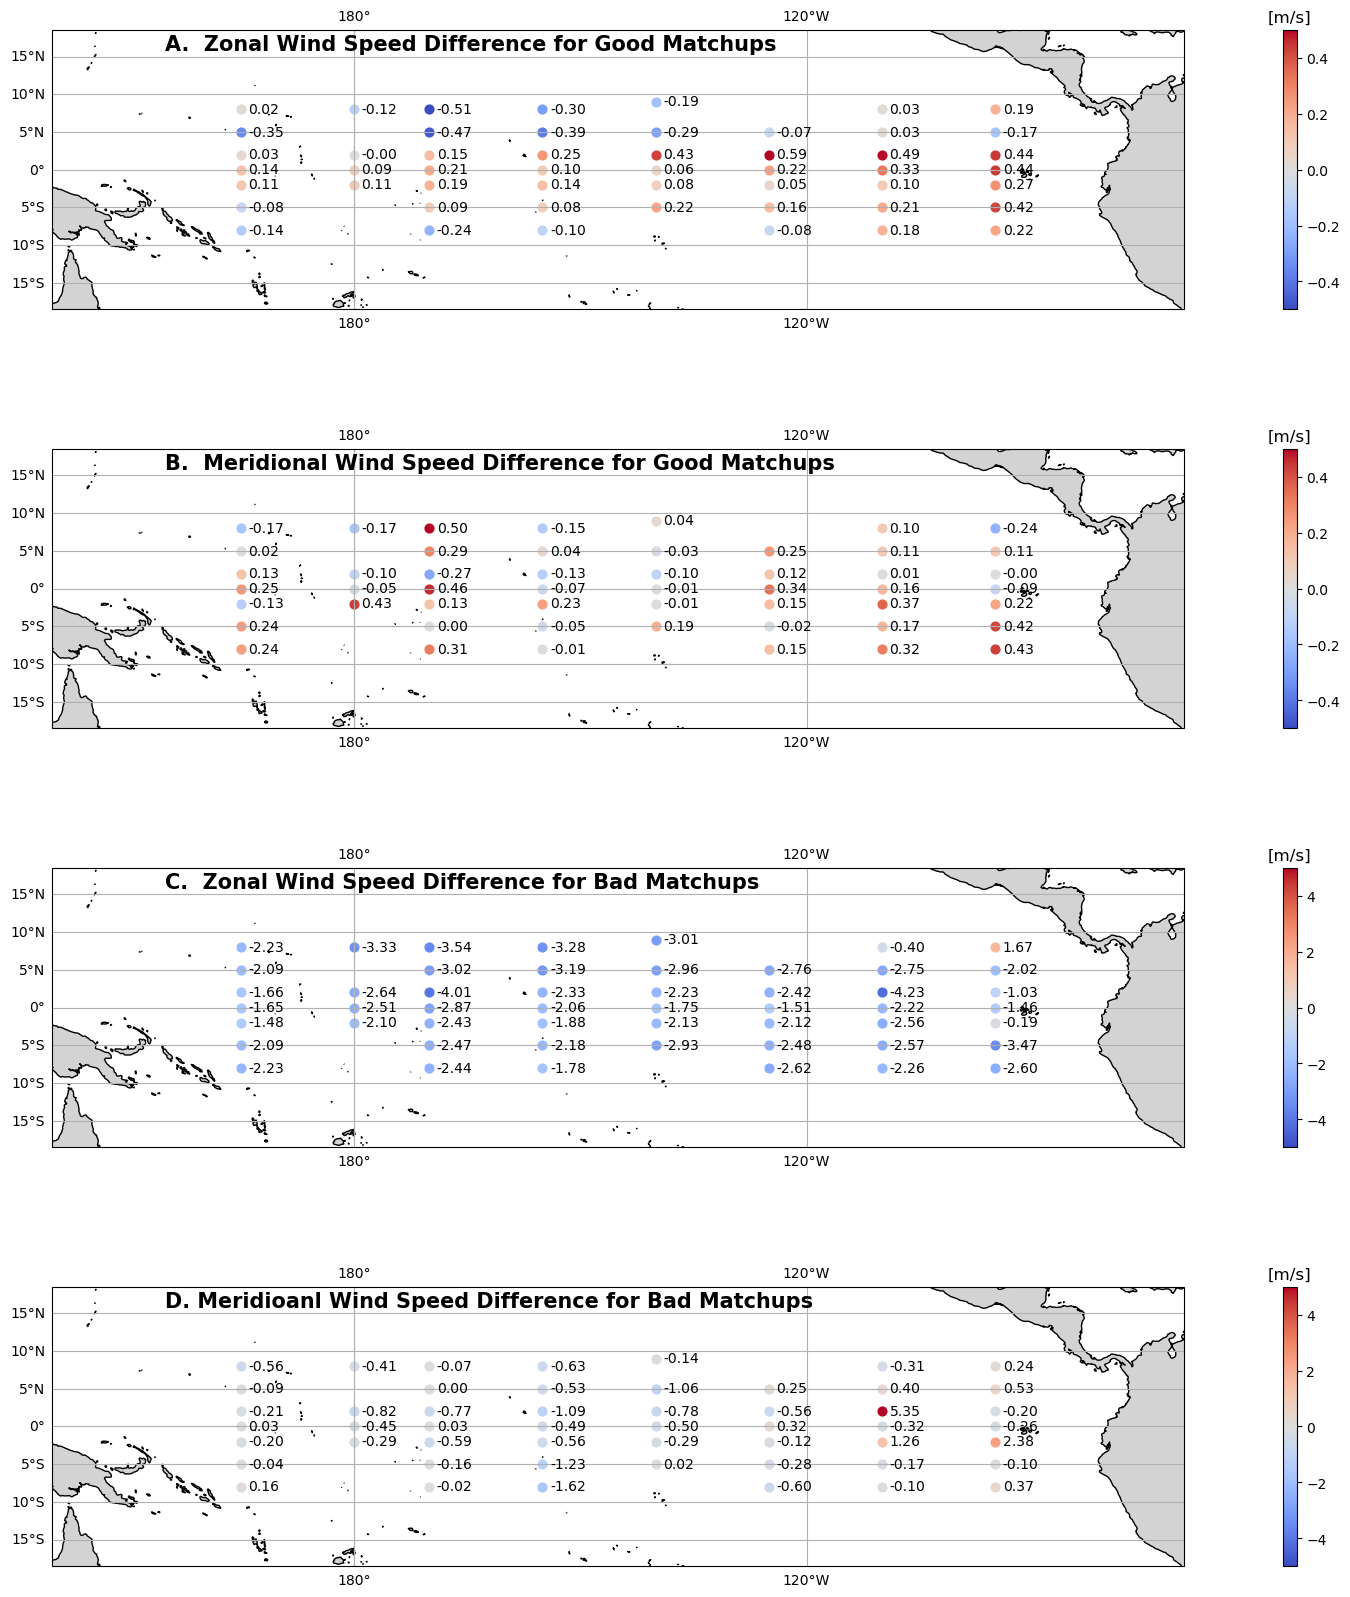

In [61]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 4, 
                       ncols = 1, 
                        figsize = (20,16),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    diff = getmeanXSpeedDiff(lat, lon, subDF)
    if diff != -999: 
        ax.text(xpos+1, lat-0.5, f'{diff:4.2f}', fontsize = 10)
        x1 = ax.scatter(xpos, lat, c=diff, vmin=-0.5, vmax=0.5, s=40, cmap='coolwarm')
    
cb = plt.colorbar(x1, ax = ax)
cb.ax.set_title('[m/s]')

ax.text(0.1, 0.95, 'A.  Zonal Wind Speed Difference for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    diff = getmeanYSpeedDiff(lat, lon, subDF)
    if diff != -999: 
        ax.text(xpos+1, lat-0.5, f'{diff:4.2f}', fontsize = 10)
        x2 = ax.scatter(xpos, lat, c=diff, vmin=-0.5, vmax=0.5, s=40, cmap='coolwarm')
    
cb = plt.colorbar(x2, ax = ax)
cb.ax.set_title('[m/s]')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'B.  Meridional Wind Speed Difference for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    diff = getmeanXSpeedDiff(lat, lon, subDF)
    if diff != -999: 
        ax.text(xpos+1, lat-0.5, f'{diff:4.2f}', fontsize = 10)
        x3 = ax.scatter(xpos, lat, c=diff, vmin=-5, vmax=5, s=40, cmap='coolwarm')
    
cb = plt.colorbar(x3, ax = ax)
cb.ax.set_title('[m/s]')

ax.text(0.1, 0.95, 'C.  Zonal Wind Speed Difference for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[3]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getmeanYSpeedDiff(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x4 = ax.scatter(xpos, lat, c=corr, vmin=-5, vmax=5, s=40, cmap='coolwarm')
    
cb = plt.colorbar(x4, ax = ax)
cb.ax.set_title('[m/s]')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'D. Meridioanl Wind Speed Difference for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

plt.savefig('goodVsBad_DifferencesbyMatchupLabel_Components.png', dpi=100)

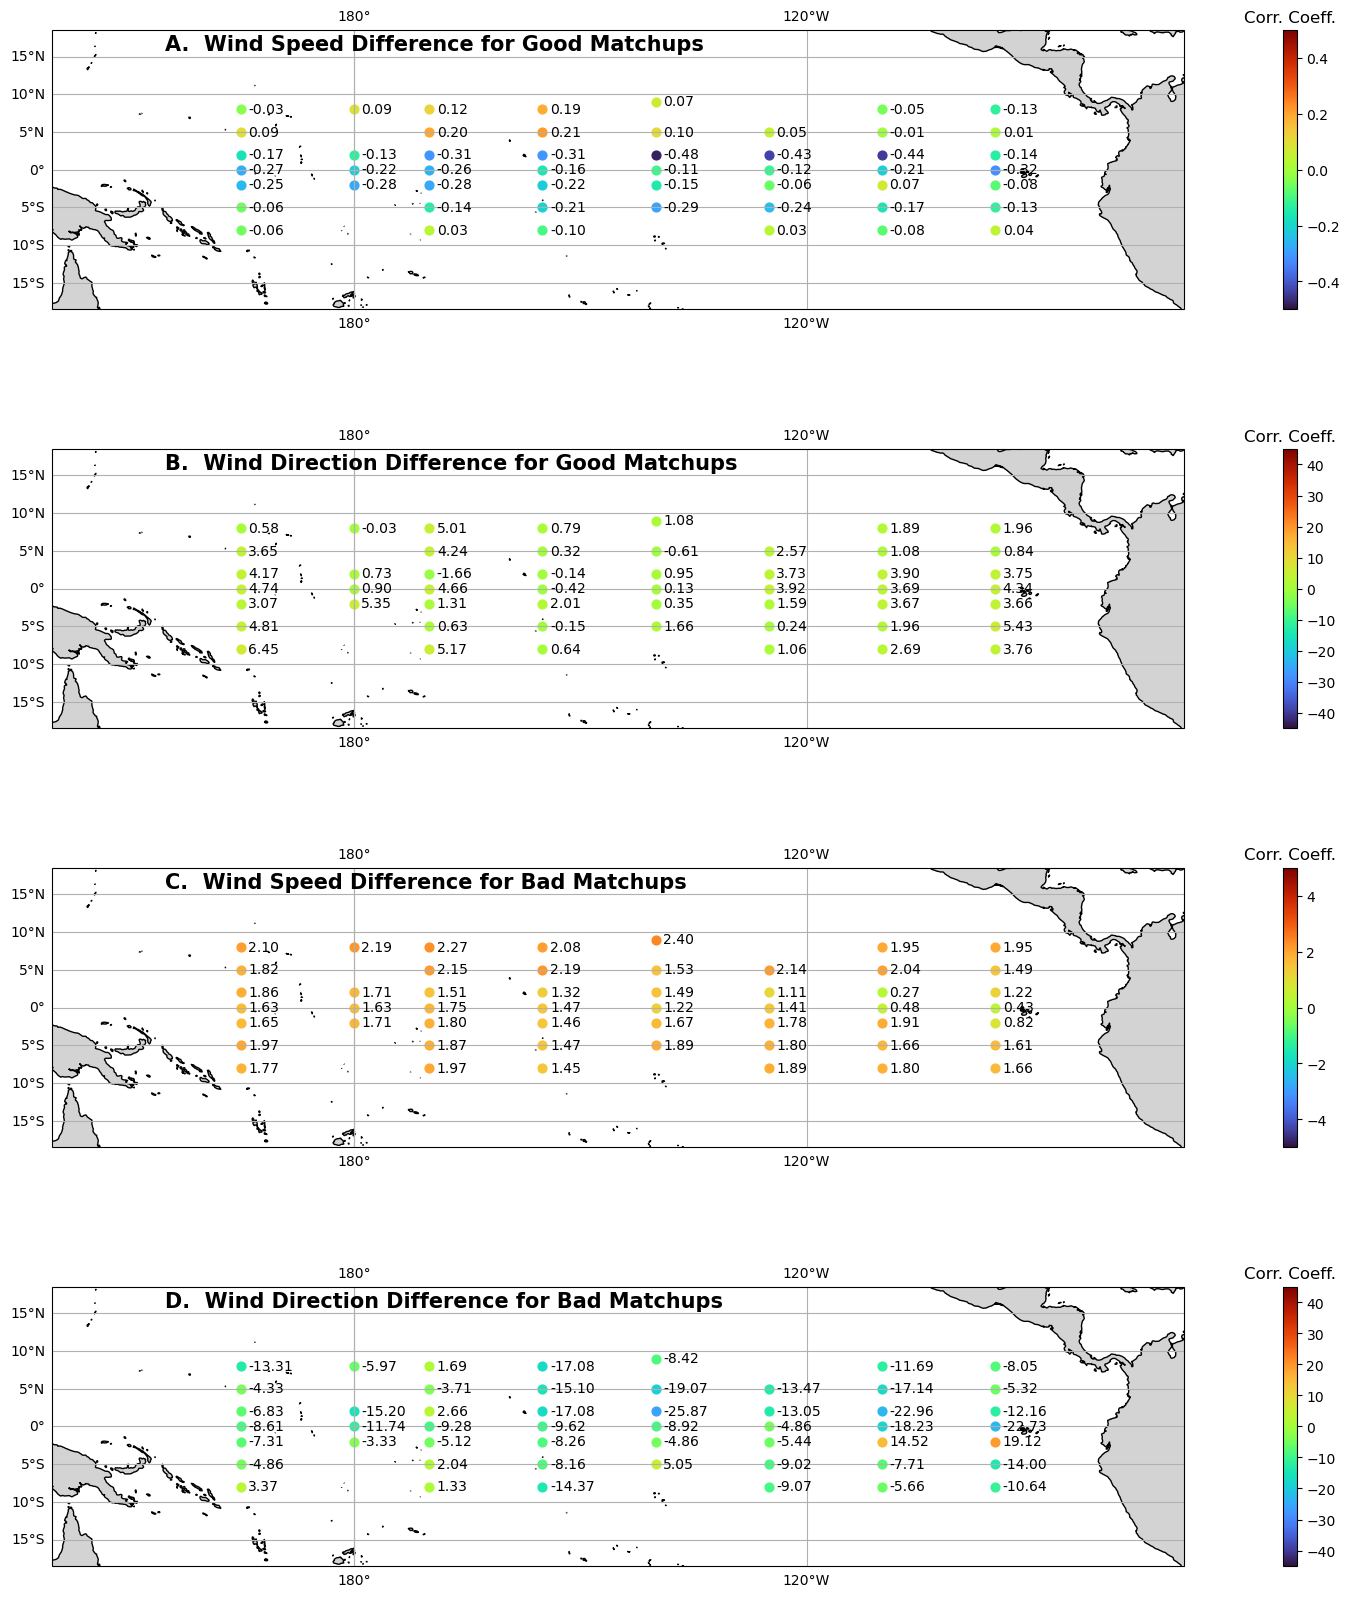

In [62]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 4, 
                       ncols = 1, 
                        figsize = (20,16),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    diff = getmeanSpeedDiff(lat, lon, subDF)
    if diff != -999: 
        ax.text(xpos+1, lat-0.5, f'{diff:4.2f}', fontsize = 10)
        x1 = ax.scatter(xpos, lat, c=diff, vmin=-0.5, vmax=0.5, s=40, cmap='turbo')
    
cb = plt.colorbar(x1, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'A.  Wind Speed Difference for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'good']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getmeanDirectionDiff(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x2 = ax.scatter(xpos, lat, c=corr, vmin=-45, vmax=45, s=40, cmap='turbo')
    
cb = plt.colorbar(x2, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'B.  Wind Direction Difference for Good Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']

for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    diff = getmeanSpeedDiff(lat, lon, subDF)
    if diff != -999: 
        ax.text(xpos+1, lat-0.5, f'{diff:4.2f}', fontsize = 10)
        x3 = ax.scatter(xpos, lat, c=diff, vmin=-5, vmax=5, s=40, cmap='turbo')
    
cb = plt.colorbar(x3, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'C.  Wind Speed Difference for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

#########################################################################################################
#########################################################################################################
#########################################################################################################

ax = axes[3]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()

subDF = df.loc[df['GoodBad'] == 'bad']
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getmeanDirectionDiff(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}', fontsize = 10)
        x4 = ax.scatter(xpos, lat, c=corr, vmin=-45, vmax=45, s=40, cmap='turbo')
    
cb = plt.colorbar(x4, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'D.  Wind Direction Difference for Bad Matchups', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

plt.savefig('goodVsBad_DifferencesbyMatchupLabel.png', dpi=100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecat

Text(0, 0.5, 'Bad Data %')

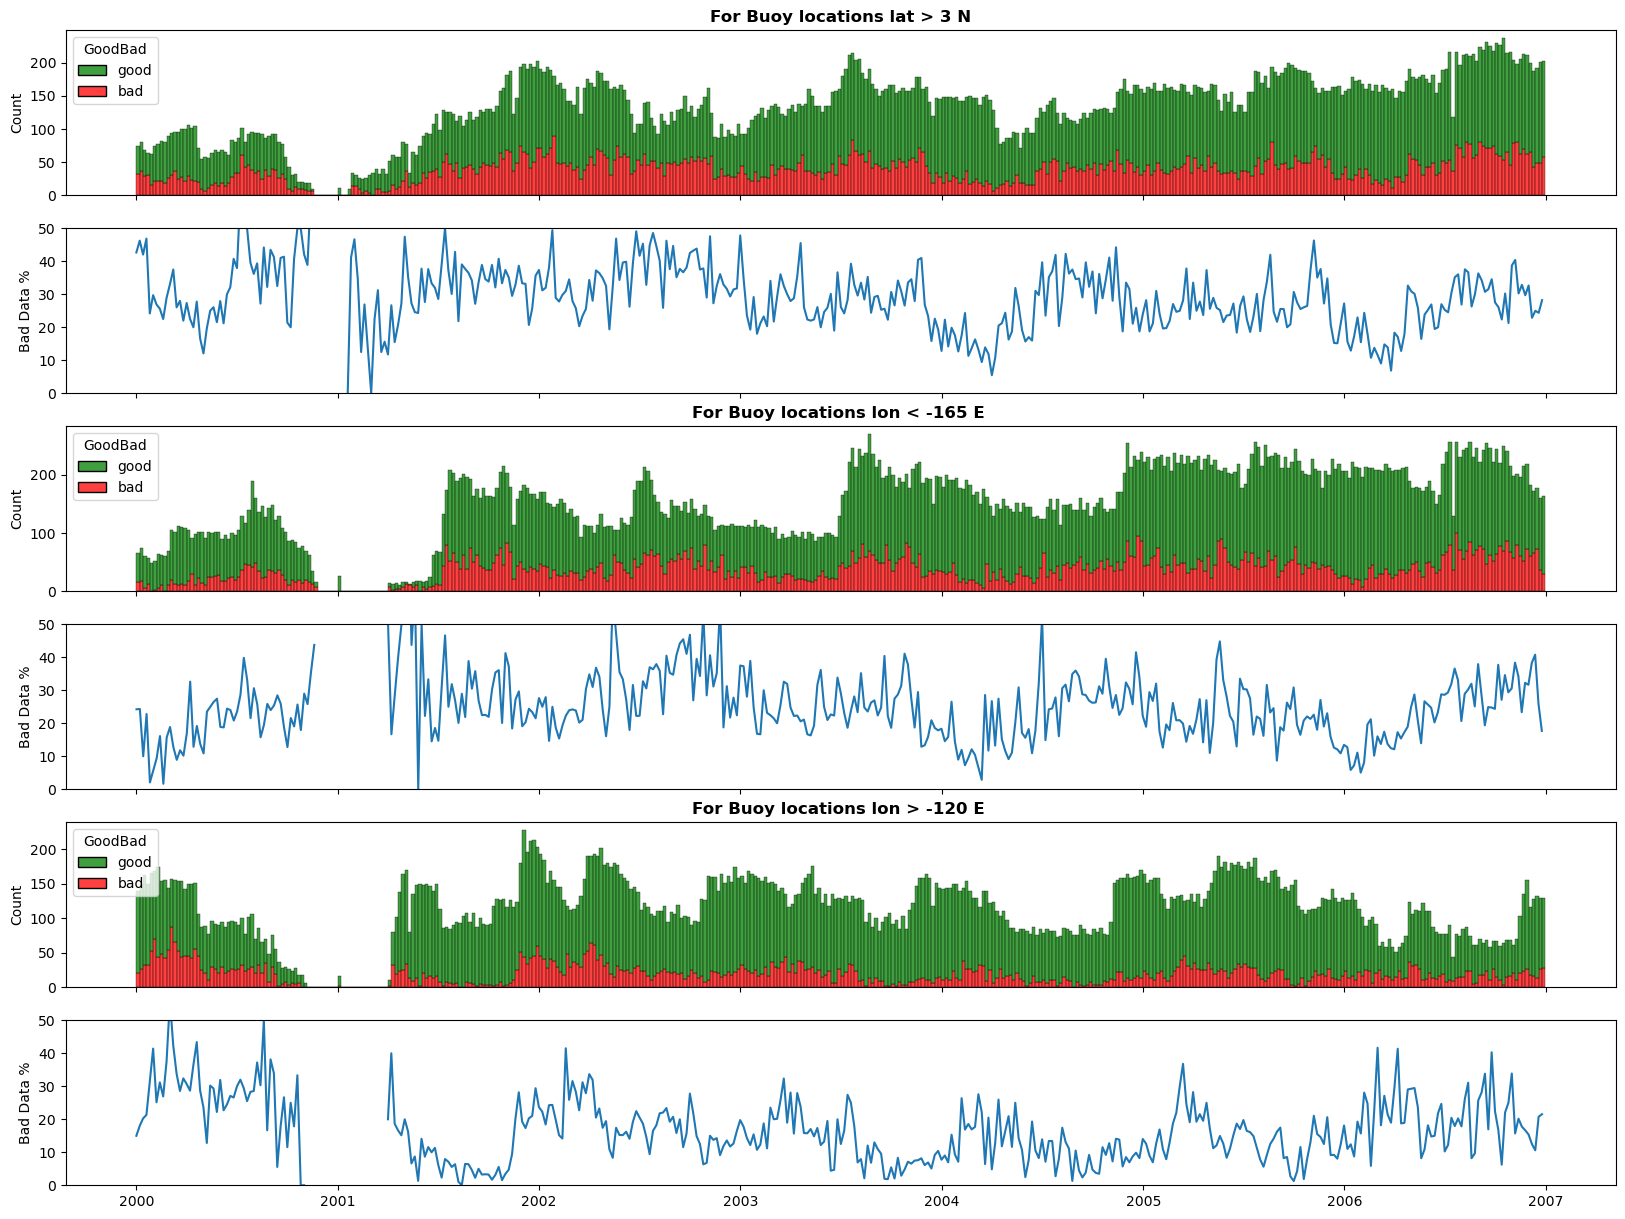

In [63]:
fig, axes = plt.subplots(nrows=6, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
nx = 12*7*5 # 168
ny = 10

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecat

Text(0.5, 0, 'Day of year')

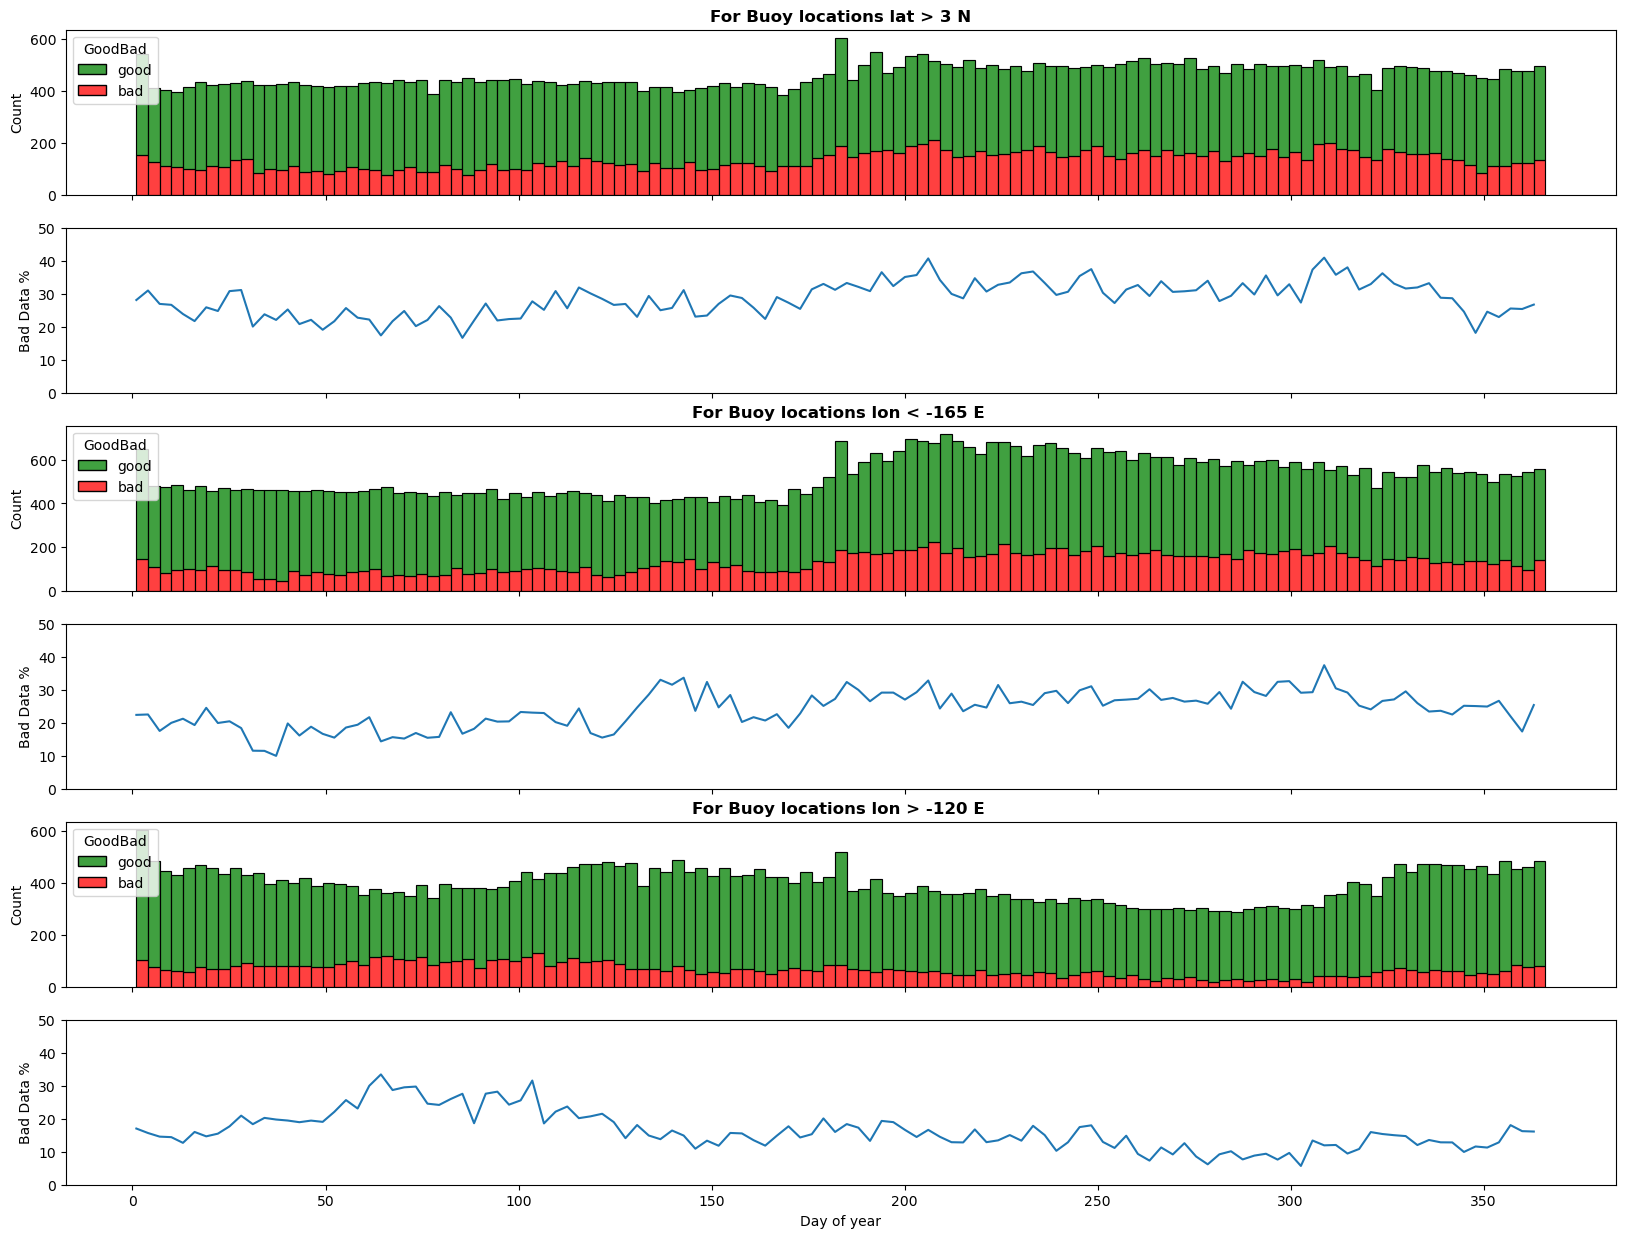

In [64]:
fig, axes = plt.subplots(nrows=6, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
nx = int(365//3)
ny = 10

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Day of year')
################################################################################################

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1194369/1893293327.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('m

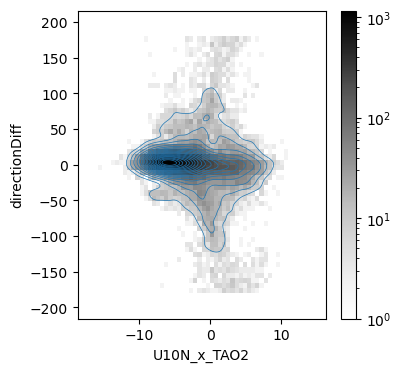

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharey=False)

def getPDF(subDF, ax, xlabel, ylabel):
    #ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                    levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)
    
    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange
    
    yrange = (ymax - ymin)
    ytol = 0.1 * yrange
    
    xmin -= xtol
    xmax += xtol
    
    ymin -= ytol
    ymax += ytol
    
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    #ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

getPDF(subDF, ax, 'U10N_x_TAO2', 'directionDiff')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecat

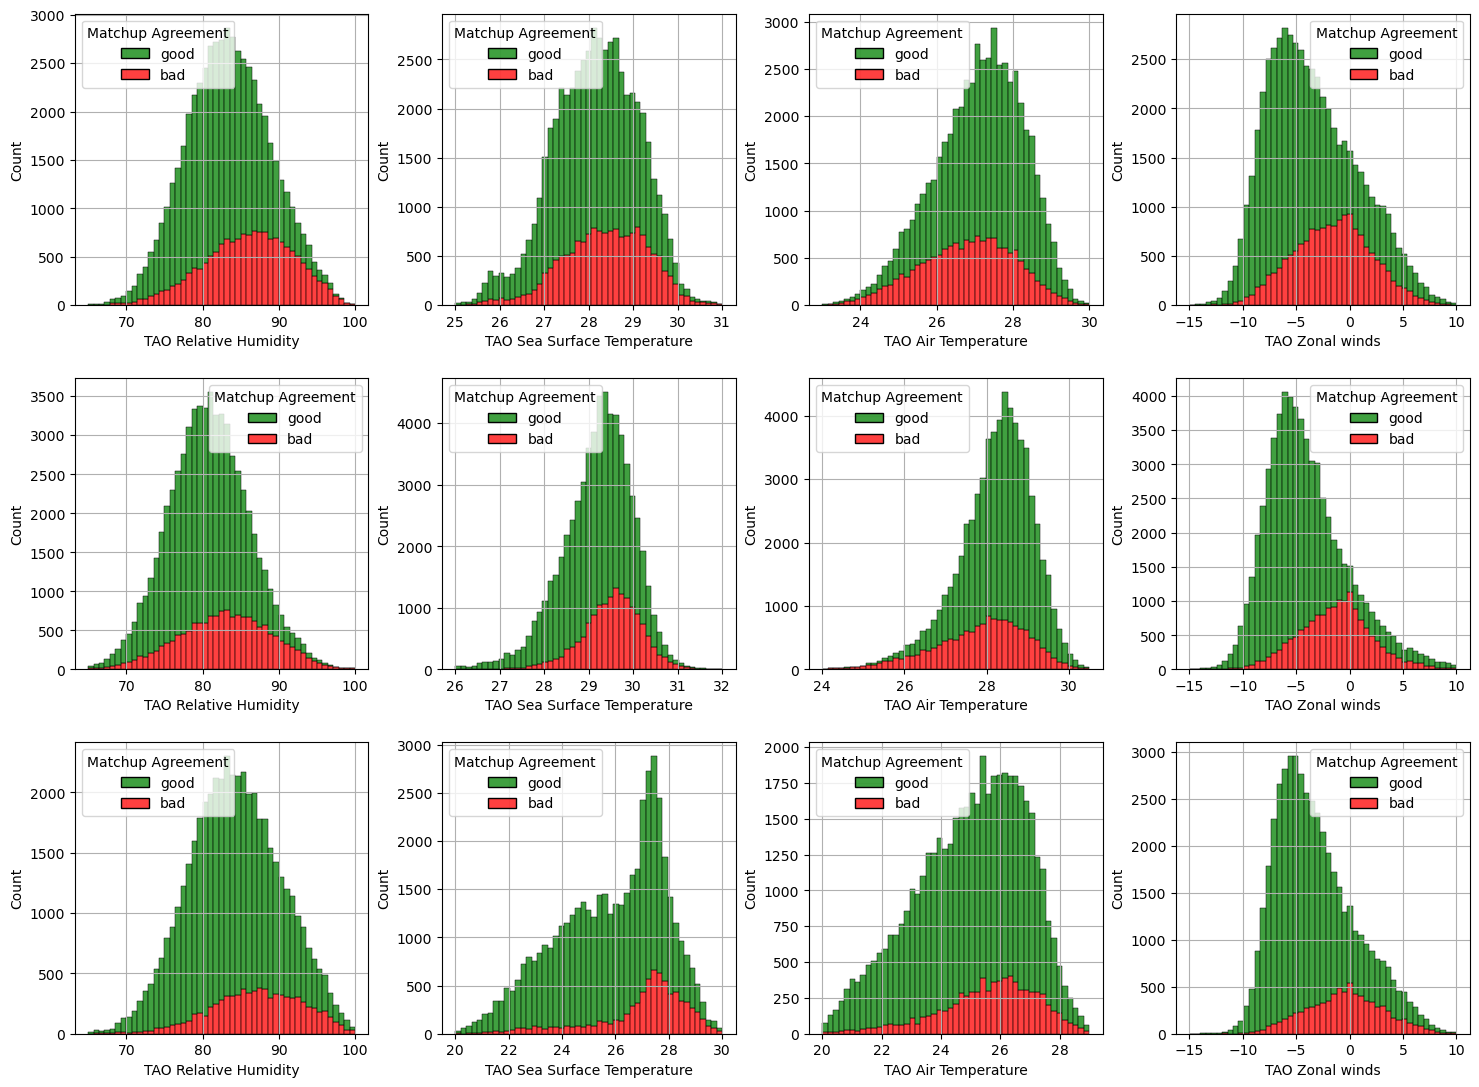

In [124]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = False, figsize=(15,12))
histkind = "stack"
cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins_RH = np.linspace(65,100,50)
custom_bins_SST = np.linspace(20,32,50)
custom_bins_AIRT = np.linspace(15,32,50)
custom_bins_U10x = np.linspace(-15,10,50)
ny = 10

xlabel = 'RH_TAO'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_RH, 
             hue='Matchup Agreement', 
             multiple=histkind,palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)

#ax.set_title(title)
ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[0,1]
xlabel = 'SST_TAO'
custom_bins_SST = np.linspace(25,31,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_SST,
             hue='Matchup Agreement', 
             multiple=histkind,palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')


ax = axes[0,2]
xlabel = 'AIRT_TAO'
custom_bins_AIRT = np.linspace(23,30,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_AIRT, 
             hue='Matchup Agreement',  
             multiple=histkind,palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'U10N_x_TAO2'
ax = axes[0,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_U10x,
             hue='Matchup Agreement',
             multiple=histkind,palette = {'good': 'green', 'bad': 'red'},
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')

################################################################################################

xlabel = 'RH_TAO'
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, 
             bins= custom_bins_RH, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')

ax = axes[1,1]
xlabel = 'SST_TAO'
custom_bins_SST = np.linspace(26,32,50)

sns.histplot(subDF.iloc[::-1], x=xlabel,
             bins= custom_bins_SST, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[1,2]
xlabel = 'AIRT_TAO'
custom_bins_AIRT = np.linspace(24,30.5,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_AIRT, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'U10N_x_TAO2'
ax = axes[1,3]

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_U10x, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
xlabel = 'RH_TAO'
title = 'For Buoy locations lon > -120 E '

ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
subDF = subDF.rename(columns = {'GoodBad':'Matchup Agreement'})
# goodDF = subDF.loc[subDF['GoodBad'] == 'good']
# badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, 
             bins = custom_bins_RH,  
             hue='Matchup Agreement', 
             multiple=histkind,  
             palette = {'good': 'green', 'bad': 'red'},
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
ax.set_xlabel('TAO Relative Humidity')
ax.grid(visible=True, which='major')
#ax.text(-0.01, 0.33, 'Eastern Pacific', transform=ax.transAxes, rotation=90)

ax = axes[2,1]
xlabel = 'SST_TAO'
custom_bins_SST = np.linspace(20,30,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_SST, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
ax.set_xlabel('TAO Sea Surface Temperature')
ax.grid(visible=True, which='major')

ax = axes[2,2]
xlabel = 'AIRT_TAO'
custom_bins_AIRT = np.linspace(20,29,50)

sns.histplot(subDF.iloc[::-1], x=xlabel, 
             bins= custom_bins_AIRT, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
ax.set_xlabel('TAO Air Temperature')
ax.grid(visible=True, which='major')

xlabel = 'U10N_x_TAO2'
ax = axes[2,3]

sns.histplot(subDF.iloc[::-1], x=xlabel,
             bins= custom_bins_U10x, 
             hue='Matchup Agreement',  
             multiple=histkind,
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
#ax.set_title(title)
ax.set_xlabel('TAO Zonal winds')
ax.grid(visible=True, which='major')


################################################################################################
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.25, hspace=0.25)
plt.savefig('StackedHistogram.png', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

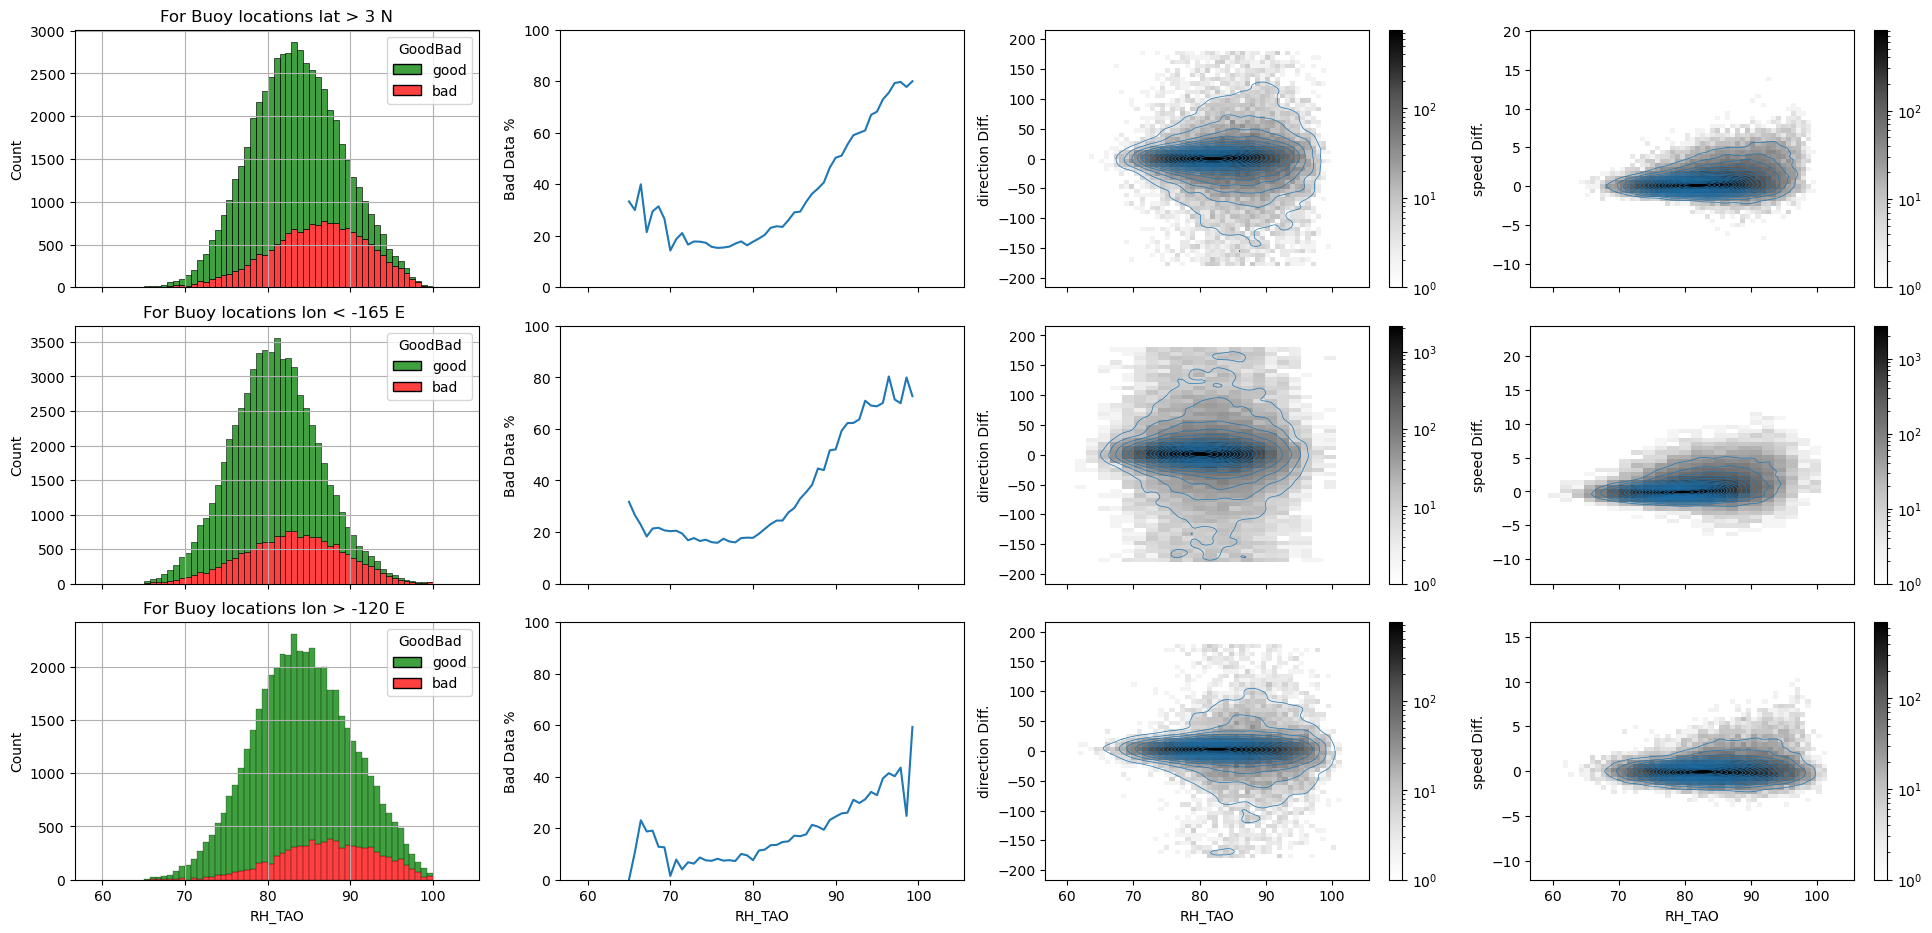

In [66]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = True, figsize=(20,10))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins = np.linspace(65,100,50)
ny = 10

xlabel = 'RH_TAO'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################


title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################


ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(xlabel)

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
plt.savefig('QuikSCAT_RH.png', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

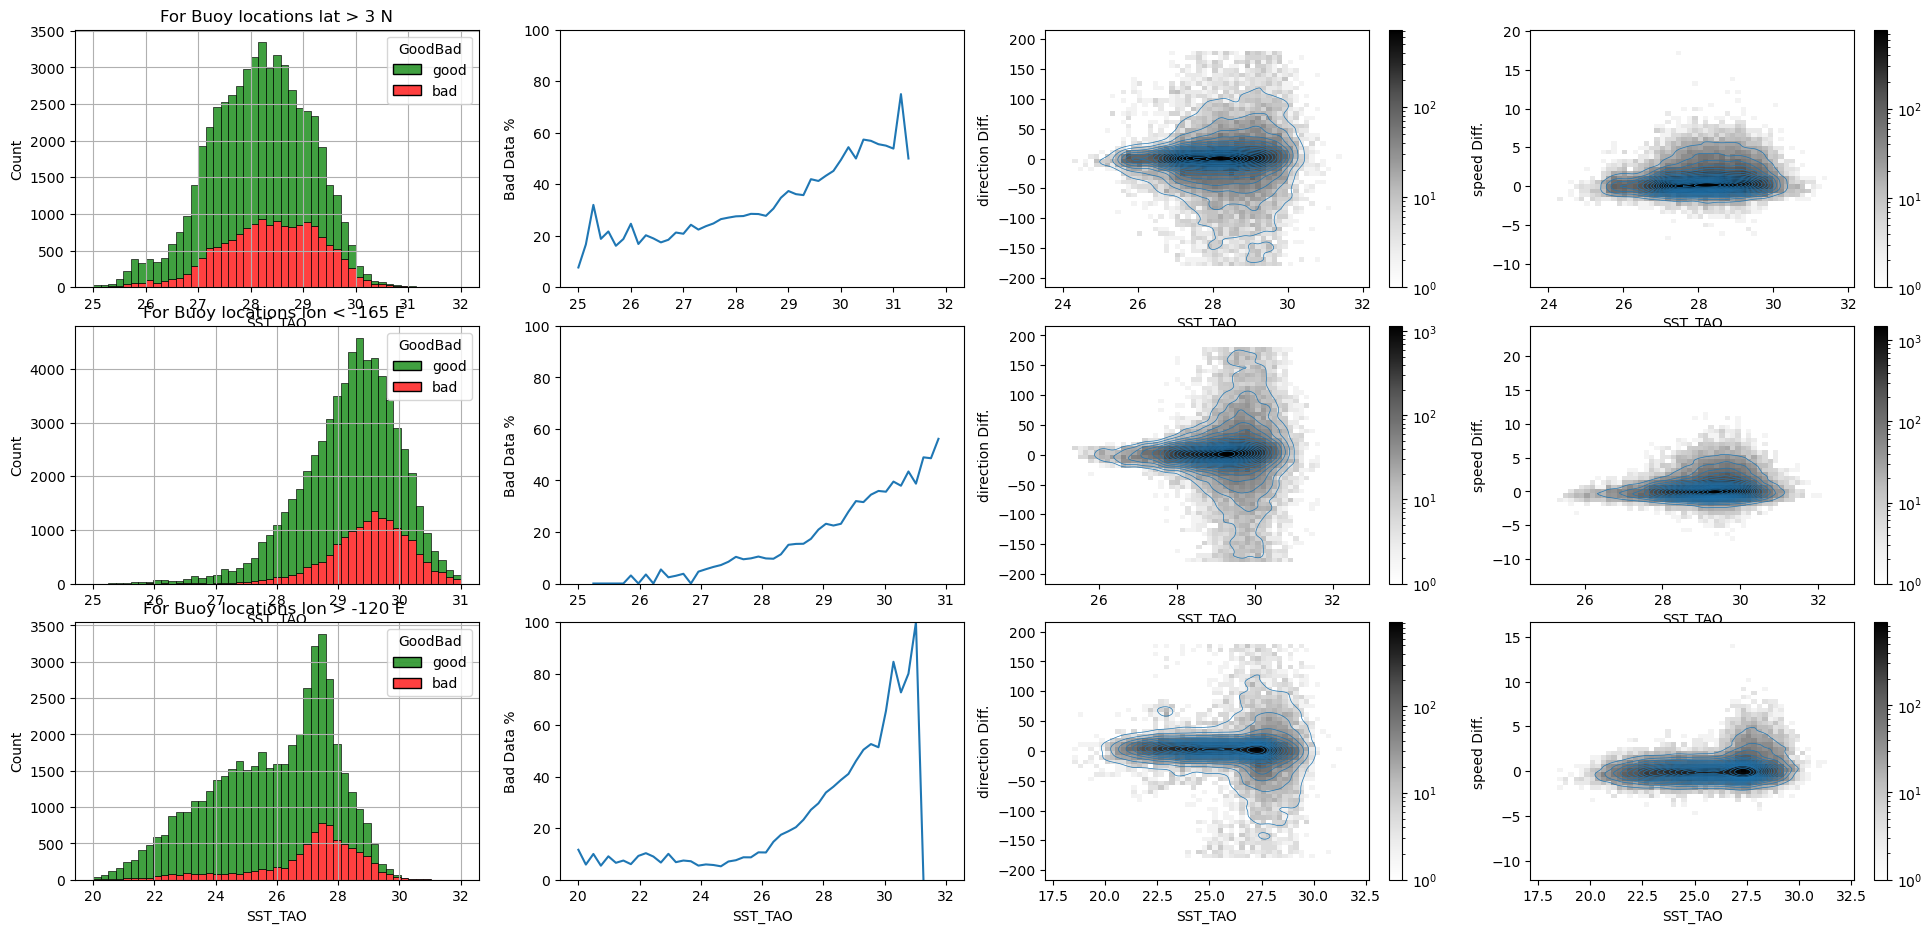

In [67]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = False, figsize=(20,10))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins = np.linspace(25,32,50)
ny = 10

xlabel = 'SST_TAO'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(xlabel)

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
plt.savefig('QuikSCAT_SST.png', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.5, 0, '$\\degree C$')

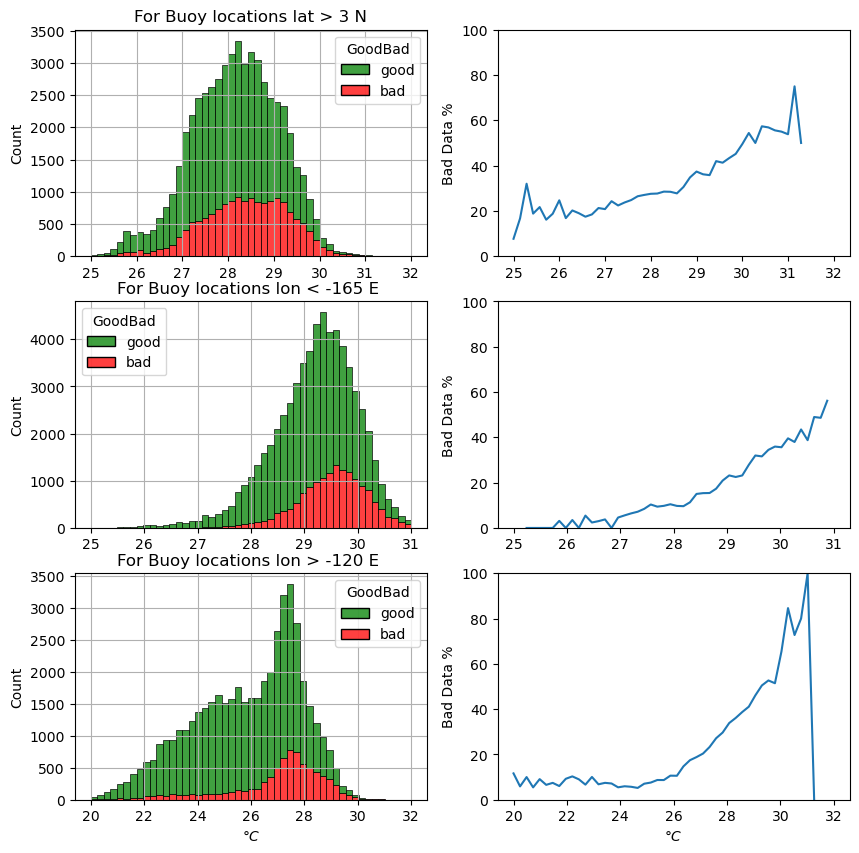

In [68]:
fig, axes = plt.subplots(nrows=3, ncols =2, sharex = False, figsize=(10,10))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins = np.linspace(25,32,50)
ny = 10

xlabel = 'SST_TAO'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel(r'$\degree C$')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(r'$\degree C$')
################################################################################################


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

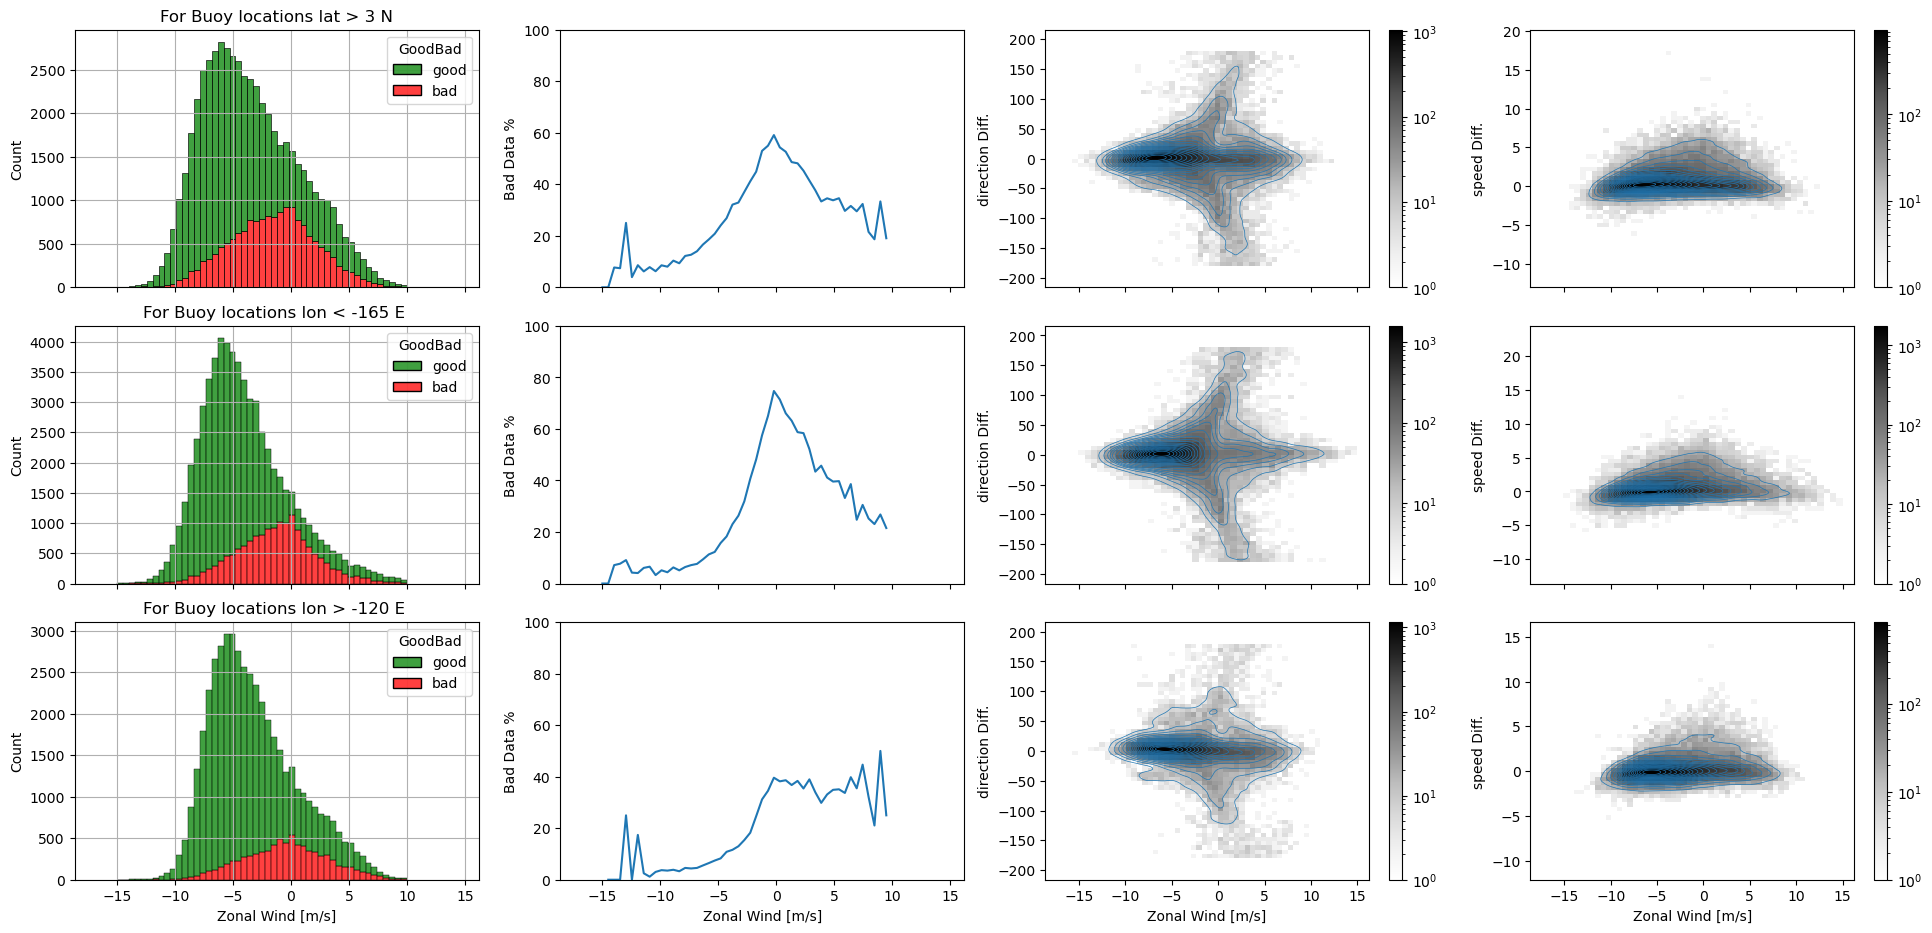

In [69]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = True, figsize=(20,10))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins = np.linspace(-15,10,50)
ny = 10

xlabel = 'U10N_x_TAO2'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

#custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

#custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_xlabel('Zonal Wind [m/s]')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
plt.savefig('QuikSCAT_zonalWinds.png', dpi = 100)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

Text(0.5, 0, 'Zonal Wind [m/s]')

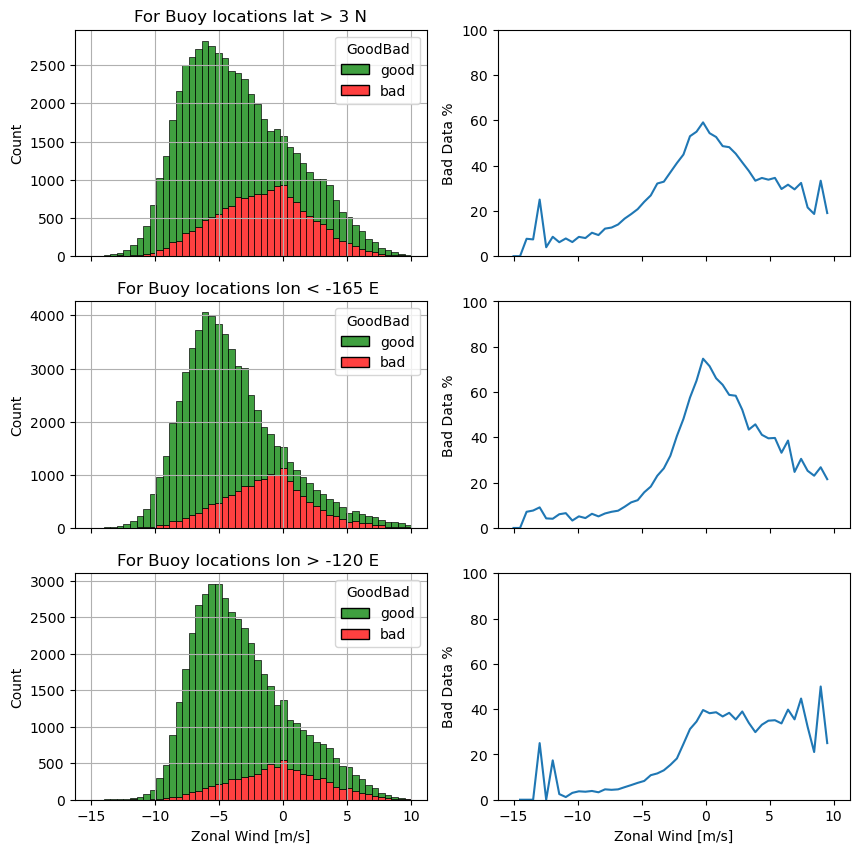

In [70]:
fig, axes = plt.subplots(nrows=3, ncols =2, sharex = True, figsize=(10,10))

cmap = plt.get_cmap('coolwarm').copy()
cmap.set_bad('white')
custom_bins = np.linspace(-15,10,50)
ny = 10

xlabel = 'U10N_x_TAO2'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

#custom_bins = np.linspace(-15,10,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

#custom_bins = np.linspace(-15,15,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Zonal Wind [m/s]')
################################################################################################


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_1194369/3600693425.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('m

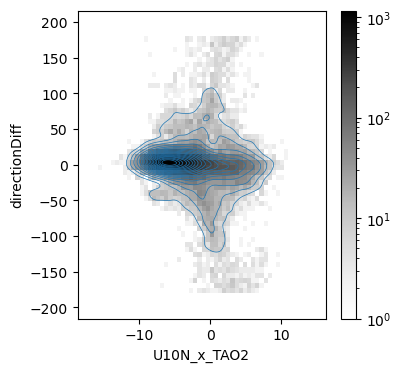

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharey=False)

def getPDF(subDF, ax, xlabel, ylabel):
    #ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                    levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)
    
    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange
    
    yrange = (ymax - ymin)
    ytol = 0.1 * yrange
    
    xmin -= xtol
    xmax += xtol
    
    ymin -= ytol
    ymax += ytol
    
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

getPDF(subDF, ax, 'U10N_x_TAO2', 'directionDiff')

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

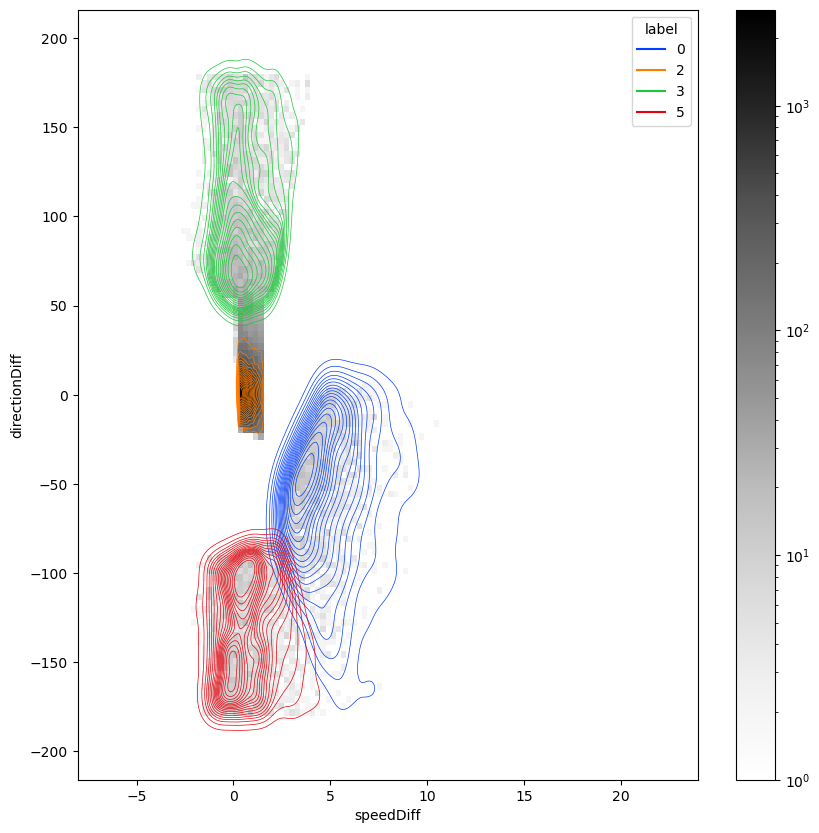

In [72]:
xlabel = 'speedDiff'
ylabel = 'directionDiff'
nx = 100
ny = 100
fig, ax = plt.subplots(figsize=(10,10))
cmap = plt.get_cmap('Greys').copy()
cmap.set_bad('white')

subDF = df.loc[df['label'].isin([0,2,3,5])]#,6,8])]

h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                   norm=colors.LogNorm())
s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                hue='label',levels=20, linewidths=0.5, 
                palette = sns.color_palette("bright"), ax = ax)

xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()

xrange = (xmax - xmin)
xtol = 0.1 * xrange

yrange = (ymax - ymin)
ytol = 0.1 * yrange

xmin -= xtol
xmax += xtol

ymin -= ytol
ymax += ytol


ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.colorbar(h1[3], ax = ax)

In [73]:
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', #common_norm=False,
#                 palette = sns.color_palette("bright"))

In [74]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density.png'
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3), sharey=True)
    
    ax = axes[0]
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, 
                    hue='label',levels=20, thres=0.1, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 0]
    ax = axes[1]
    h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[0], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h1[3], ax = ax)
    

    ssubDF = subDF.loc[subDF['label'] == 1]
    ax = axes[2]
    h2 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[1], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h2[3], ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 2]
    ax = axes[3]
    h3 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[2], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h3[3], ax = ax)

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

In [75]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density_errorsOnly_of_each_cluster.png'
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharey=False)
    
    ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange

    yrange = (ymax - ymin)
    ytol = 0.1 * yrange

    xmin -= xtol
    xmax += xtol

    ymin -= ytol
    ymax += ytol


    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    ax.set_xlabel(None)
    
    
    for i in range(1,10):
        ii = int(i//5)
        jj = int(i%5)
        ssubDF = subDF.loc[subDF['label'] == i-1]
        ax = axes[ii, jj]
        h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Greys'), 
                       norm=colors.LogNorm())
        s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                        levels=10, linewidths=0.5, 
                        color = 'Red', ax = ax)
        if ii == 1:
            ax.set_xlabel(xlabel)
        else:
            ax.set_xlabel(None)

        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel(None)
            
        xmin, xmax = ssubDF[xlabel].min(), ssubDF[xlabel].max()
        ymin, ymax = ssubDF[ylabel].min(), ssubDF[ylabel].max()
        
        xrange = (xmax - xmin)
        xtol = 0.1 * xrange
    
        yrange = (ymax - ymin)
        ytol = 0.1 * yrange
    
        xmin -= xtol
        xmax += xtol
    
        ymin -= ytol
        ymax += ytol
        
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(f'label = {i-1:d}')
        plt.colorbar(h1[3], ax = ax)
    

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

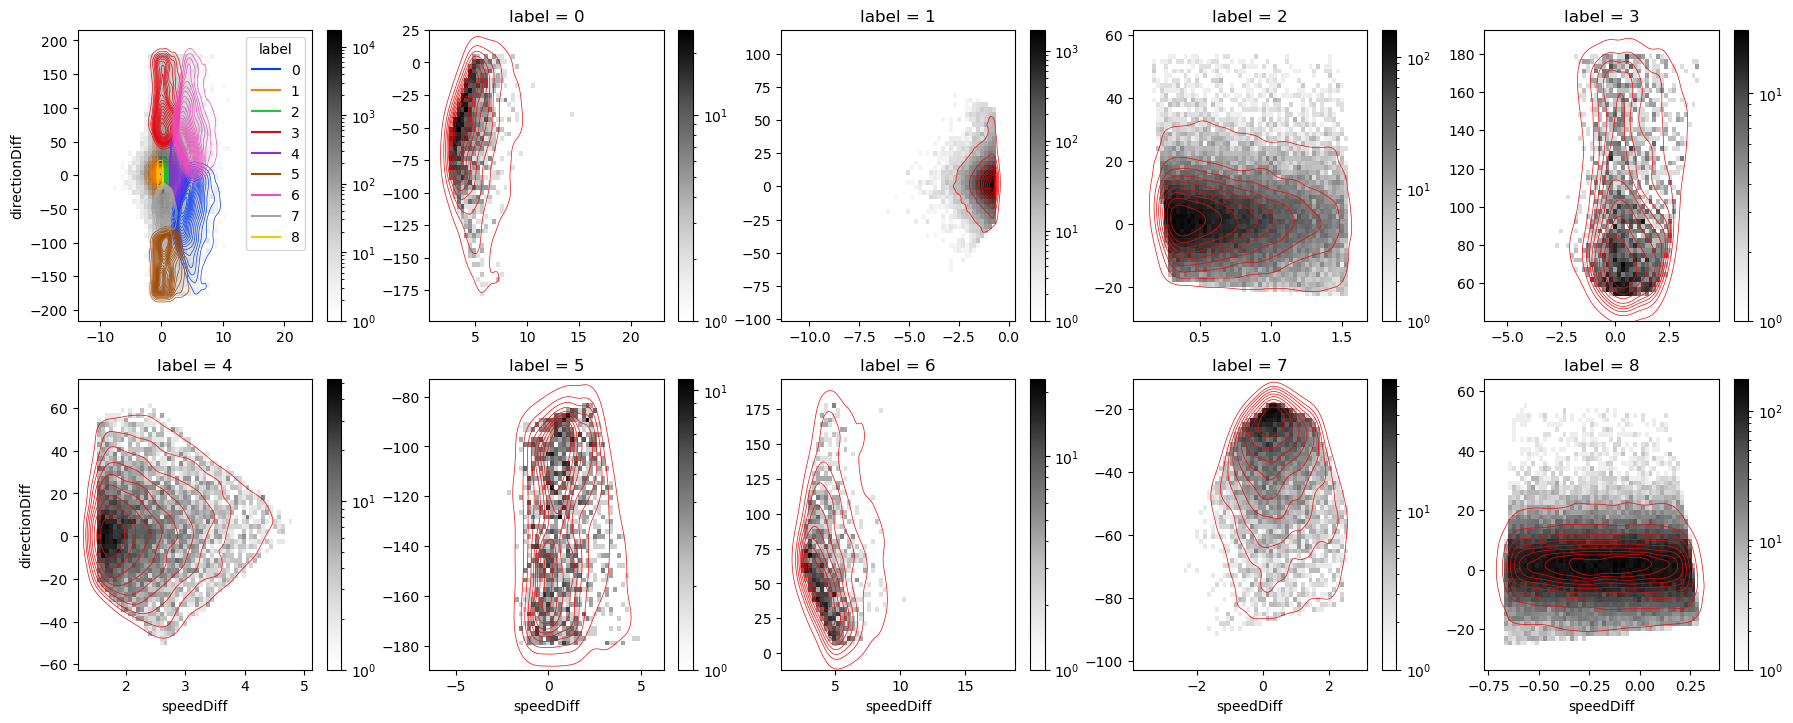

In [76]:
pdfPlotTest('speedDiff', 'directionDiff', df, nx = 50, ny =50)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

<Axes: xlabel='speedDiff', ylabel='directionDiff'>

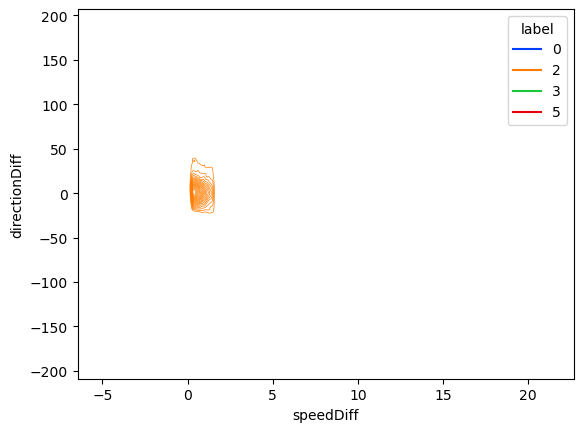

In [77]:
sns.kdeplot(subDF, x='speedDiff', y='directionDiff', 
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"))

In [78]:
for i in range(len(subDFheaders)-1):
    for j in range(i+1, len(subDFheaders)):
        xlabel = subDFheaders[i]
        ylabel = subDFheaders[j]:
        if xlabel != ylabel:
            print(xlabel, ylabel)
            pdfPlotTest(xlabel, ylabel, subDF)

SyntaxError: invalid syntax (1772201387.py, line 4)

In [ ]:
testDF = df.loc[df['label'] == 1]
testDF.head()

In [ ]:
def pdfPlot1d(subDF, var):
    fname = f'{var}_density.png'
    fig, ax = plt.subplots(figsize=(10,6))
    s = sns.kdeplot(subDF, x=var, hue='label', ax=ax)
    fig.savefig(fname, dpi = 100)
    plt.close()

In [ ]:
for xlabel in subDFheaders:
    print(xlabel)
    pdfPlot1d(subDF, xlabel)

In [ ]:
sns.kdeplot(subDF, x='speedDiff', y='directionDiff', hue='label', levels=20)

In [ ]:
sns.kdeplot(df, x='absSpeedDiff', y='absDirectionDiff', hue='label', levels=20)